# Task2: Clustering

1. [Import libraries](#import-libraries)
2. [Loading dataset](#loading-dataset)
3. [Normalization](#normalization)
4. [K-Means](#kmeans)
    - [Estimating best k using silhouette](#silhouette)
    - [Estimating best k using distortion/SSE/inertia](#sse)
    - [Estimating best k using Davies Boulding metric](#davies-bouldin)
    - [Estimating best k using Calinski Harabasz metric](#calinski-harabasz)
    - [Putting all together and choosing the best k](#choose-k)
    - [Cluster understanding](#cluster-understanding)
5. [Hierarchical clustering](#hierarchical)
    - [Agglomerative clustering using complete method](#complete)
    - [Agglomerative clustering using ward method](#ward)
    - [Agglomerative clustering using average method](#average)
    - [Cluster understanding](#cluster-understanding-hiera)
6. [Density Based clustering](#db-clustering)
7. [Additional clustering algorithms considered](#additional-algos)
    - [X-Means](#xmeans)
    - [G-Means](#gmeans)
    - [Fuzzy clustering](#fuzzy-clustering)

## Importing libraries<a name="import-libraries"></a>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score 
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

import yellowbrick.style
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from pyclustering.cluster.gmeans import gmeans
from pyclustering.cluster.fcm import fcm
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

## Loading the datasets<a name="loading-dataset"></a>

In [2]:
df_new_num = pd.read_csv('data/df_new_num.csv', index_col=0) #all numerical features
df_new_all = pd.read_csv('data/df_new_all.csv', index_col=0) #all features
df_new_all = df_new_all[df_new_all['rank'] != -1]

indicators = ['tourPlayed', 'maxAceSvpt', 'avgDfSvpt', '1sv2svWon', 'bpS_bpF', 'win_ratio']
df_clst = df_new_num[indicators].copy(deep=True) #significant indicators
df_clst.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tourPlayed  1971 non-null   int64  
 1   maxAceSvpt  1971 non-null   float64
 2   avgDfSvpt   1971 non-null   float64
 3   1sv2svWon   1971 non-null   float64
 4   bpS_bpF     1971 non-null   float64
 5   win_ratio   1971 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 107.8 KB


In [3]:
df_new_num

rank      ht   age  tourPlayed  maxAceSvpt  avgDfSvpt  1sv2svWon  \
0     1398.00  186.54  24.0           5        6.03       6.95      57.24   
1      436.00  173.92  26.0           5        3.06       7.32      49.14   
2      918.00  186.54  21.0           5        4.06       4.72      59.64   
3      493.22  173.92  37.0           8        3.52       4.41      53.44   
4      530.00  173.92  26.0          12        0.76       5.11      52.57   
...       ...     ...   ...         ...         ...        ...        ...   
1966   191.00  186.54  22.0          25        2.75       2.99      62.20   
1967   611.00  173.92  22.0           8        2.33       4.63      56.17   
1968   435.00  173.92  16.0           6        1.47       9.59      40.77   
1969   347.00  186.54  21.0          34        2.54       3.56      56.34   
1970   473.00  173.92  31.0           6        0.74       7.24      43.60   

      bpS_bpF  win_ratio  
0       61.81      18.18  
1       41.58       0.00  
2       61.79      46.67  
3       48.60       0.00  
4       55.29      57.14  
...       ...        ...  
1966    56.99      63.64  
1967    56.24      47.06  
1968    36.56      14.29  
1969    51.41      54.65  
1970    41.47      14.29  

[1971 rows x 9 columns]

## Normalization<a name="normalization"></a>

We normalize our data using the MinMax normalization, this kind of scaling will reduce the range of our data from 0 to 1 and it will preserve the shape of the original distribution, which is fundamental for out clustering analysis. 

In [4]:
minmax_scaler = MinMaxScaler()
df_normalized = minmax_scaler.fit_transform(df_clst.values)

## K-Means<a name="kmeans"></a>

First we consider K-Means, a clustering algorithm where we need to specify the expected number of clusters. Each cluster is associated and identified with a centroid (center point of the cluster) and each point of the dataset will be assigned to the cluster which has the closest centroid

In [5]:
model = KMeans(random_state=69)

def plot_elbow(df, k_max_value, metric, elbow=True):
    vis = KElbowVisualizer(model, k=k_max_value, metric=metric, timings=False, locate_elbow=elbow)
    vis.ax.set_xticks(range(2, k_max_value+1, 2))
    vis.fit(df)

    plt.title(f"{metric} score elbow for K-Means Clustering (K = {k_max_value})")

    plt.show()

### Estimating best k using silhouette<a name="silhouette"></a>

The Silhouette Coefficient is calculated using the mean intra-cluster distance (`a`, the mean distance between a sample and all other points in the same class) and the mean nearest-cluster distance (`b`, the mean distance between a sample and all other points in the next nearest cluster) for each sample. The Silhouette Coefficient for a sample is computed as `(b - a) / max(a, b)`.  

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters, as a consequence the score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.

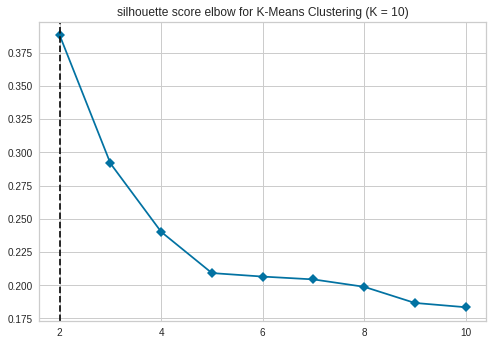

In [6]:
plot_elbow(df_normalized, k_max_value=10, metric='silhouette')

### Estimating best k using distortion/SSE/inertia<a name="sse"></a>

Error Sum of Squares (SSE) is the sum of the squared differences between each sample and its group's mean. It can be used as a measure of variation within a cluster and is the most common metric. 

SSE tends to decrease toward 0 as we increase k (with the limit case of SSE=0 when k is equal to the number of data points in the dataset)

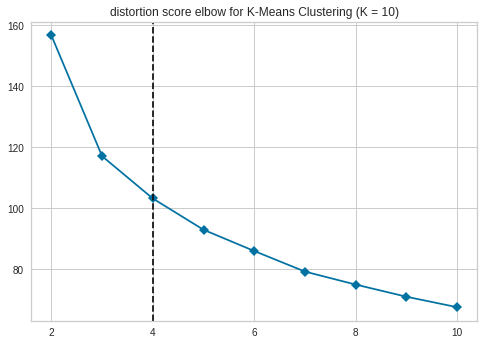

In [7]:
plot_elbow(df_normalized, k_max_value=10, metric='distortion')

### Estimating best k using Davies Bouldin metric<a name="davies-bouldin"></a>

This index indicates the average ‘similarity’ between clusters, where the similarity is a measure that compares the distance between clusters with the size of the clusters themselves.

Values closer to 0 indicate a better partition, with 0 the lowest possible score. 

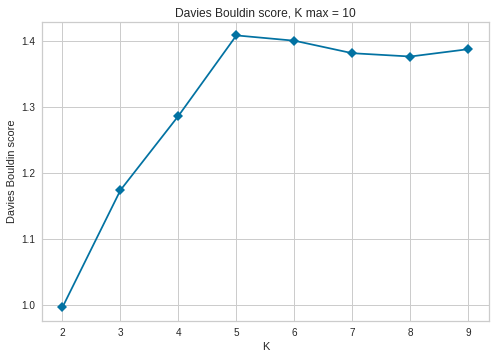

In [8]:
db_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=69)

    db_scores.append(davies_bouldin_score(df_normalized, kmeans.fit_predict(df_normalized)))
    
plt.plot(range(2, 10), db_scores, linestyle='-', marker='D', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.xticks(range(2, 10, 1))
plt.title('Davies Bouldin score, K max = 10');

### Estimating best k using Calinski Harabasz metric<a name="calinski-harabasz"></a>

A higher Calinski-Harabasz score relates to a model with better defined clusters.

The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared)

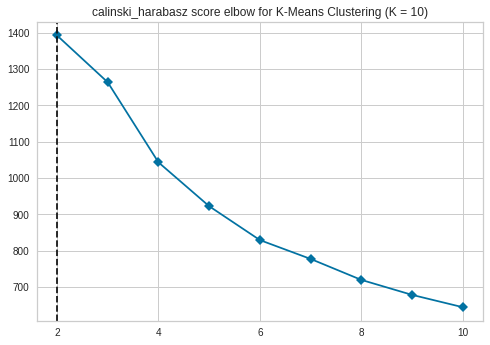

In [9]:
plot_elbow(df_normalized, k_max_value=10, metric='calinski_harabasz')

### Putting all together and choosing the best k<a name="choose-k"></a>

We construct a dataset that will contain all the computed measures discussed before and then we will choose what is our optimal value of `k`.

In [10]:
labels = []
inertia = []
kcandidates = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for k in kcandidates:
    kmeans = KMeans(n_clusters=k, random_state=69) 
    kmeans.fit(df_normalized)
    labels.append(kmeans.labels_) 
    inertia.append(kmeans.inertia_)

sse = []
sep = []
sil = []
cal_har = []
print(indicators)
for i in range(len(kcandidates)):
    sse.append(inertia[i])
    sep.append(davies_bouldin_score(df_normalized, labels[i]))
    sil.append(silhouette_score(df_normalized, labels[i]))
    cal_har.append(calinski_harabasz_score(df_normalized, labels[i]))

metrics_K = pd.DataFrame()
metrics_K['K'] = kcandidates
metrics_K['SSE/inertia/distortion'] = sse
metrics_K['Davies_Bouldin'] = sep
metrics_K['Silhouette'] = sil
metrics_K['Calinski_Harabasz'] = cal_har
metrics_K

['tourPlayed', 'maxAceSvpt', 'avgDfSvpt', '1sv2svWon', 'bpS_bpF', 'win_ratio']


K  SSE/inertia/distortion  Davies_Bouldin  Silhouette  Calinski_Harabasz
0   2              156.704533        0.996534    0.387976        1392.693559
1   3              117.129354        1.174053    0.291603        1263.622222
2   4              103.264559        1.286649    0.240143        1043.073356
3   5               93.014211        1.408638    0.209135         922.235558
4   6               86.050243        1.400595    0.206496         828.896477
5   7               79.305849        1.381648    0.204364         776.964812
6   8               75.053124        1.376640    0.198813         719.220232
7   9               71.073481        1.387772    0.186656         677.954709
8  10               67.636216        1.371017    0.183442         643.996958

Here it seems that `k = 2` seems the best choice, especially considering the silhouette metric (we want to get more dense and defined clusters).

[[0.47318668 0.36060026 0.17329844 0.73762764 0.64191645 0.61198146]
 [0.08721709 0.10921443 0.2091849  0.65240586 0.57000995 0.40009601]]


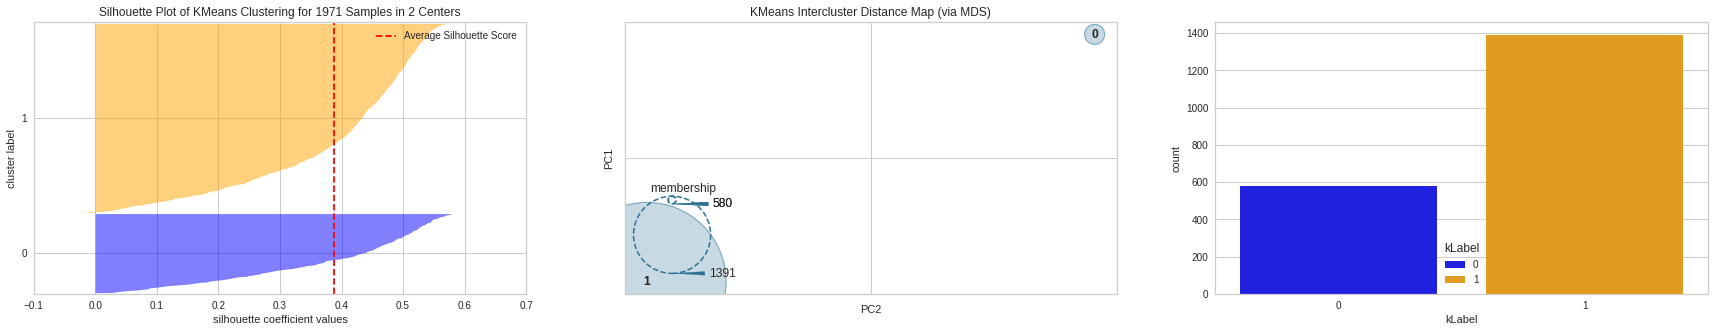

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30,5))
cluster_colors = ["blue", "orange"]
model = KMeans(n_clusters=2, random_state = 69) 

visualizer1 = SilhouetteVisualizer(model, colors=cluster_colors, ax=axs[0])
visualizer1.fit(df_normalized)
df_clst["kLabel"] = visualizer1.labels_
visualizer1.finalize()

visualizer2 = InterclusterDistance(model, ax=axs[1])
visualizer2.fit(df_normalized)
visualizer2.finalize()

print(model.cluster_centers_)
p = sns.countplot(x="kLabel", hue="kLabel", data=df_clst, ax=axs[2], palette=cluster_colors, dodge=False)
#centroids = standard_scaler.inverse_transform(model.cluster_centers_)
centroids = minmax_scaler.inverse_transform(model.cluster_centers_)
#centroids = robust_scaler.inverse_transform(model.cluster_centers_)
plt.show()

We identify two main clusters that seems to be heavy unbalanced. As we will see later, cluster `1` is related to low-normal tier players while cluster `0` is related to high tier players that have played a lot of tournaments.

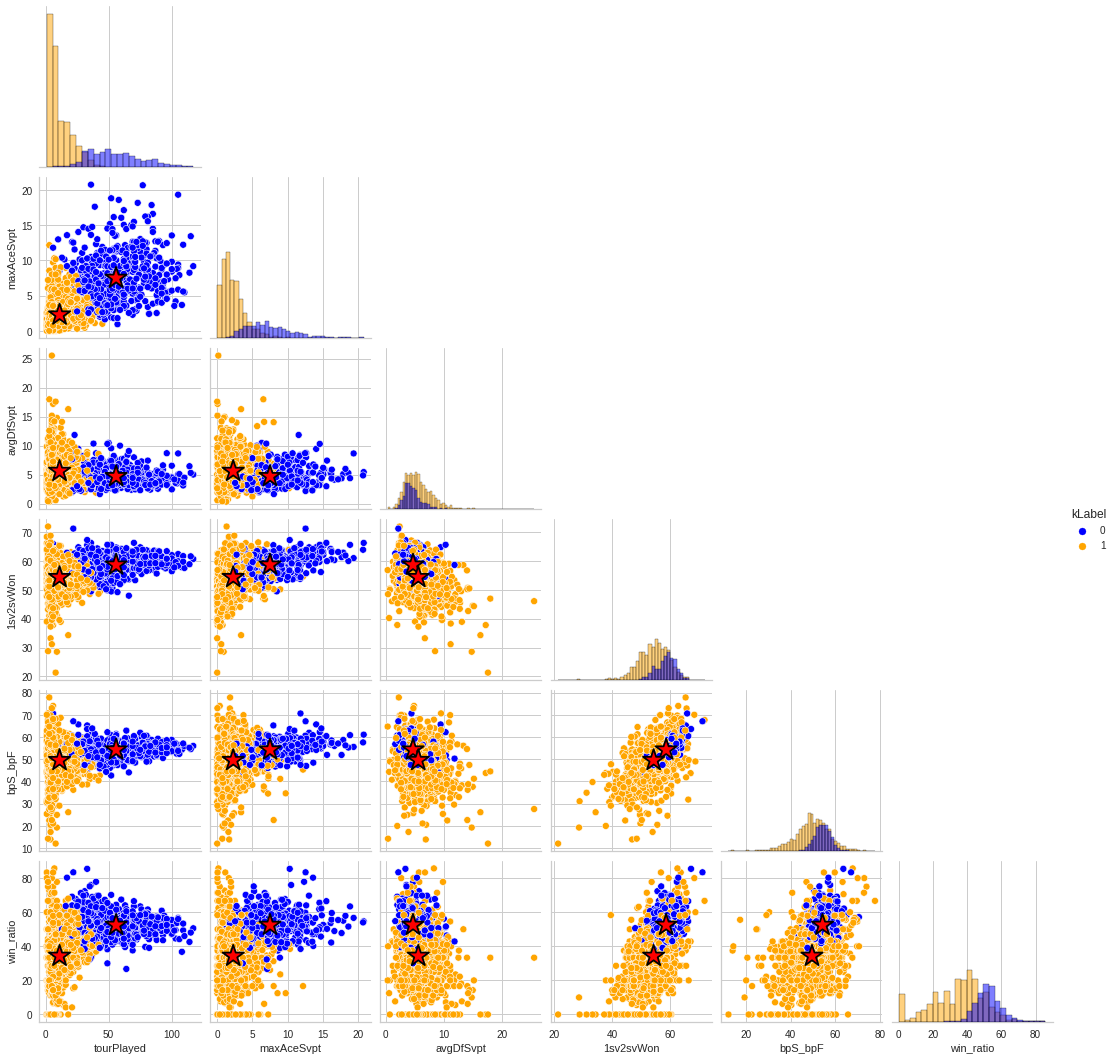

In [12]:
df_centroids = pd.DataFrame(centroids, columns=df_clst.columns[:-1])
df_centroids['kLabel'] = [0, 1]

g = sns.pairplot(
    df_clst, 
    hue="kLabel", 
    corner=True, 
    diag_kind="hist",
    palette=cluster_colors)


g.data = df_centroids
g.hue_vals = [0, 1]

g.map_offdiag(sns.scatterplot, s=500, marker="*", palette=['red', 'red'], edgecolor="black")

plt.show()

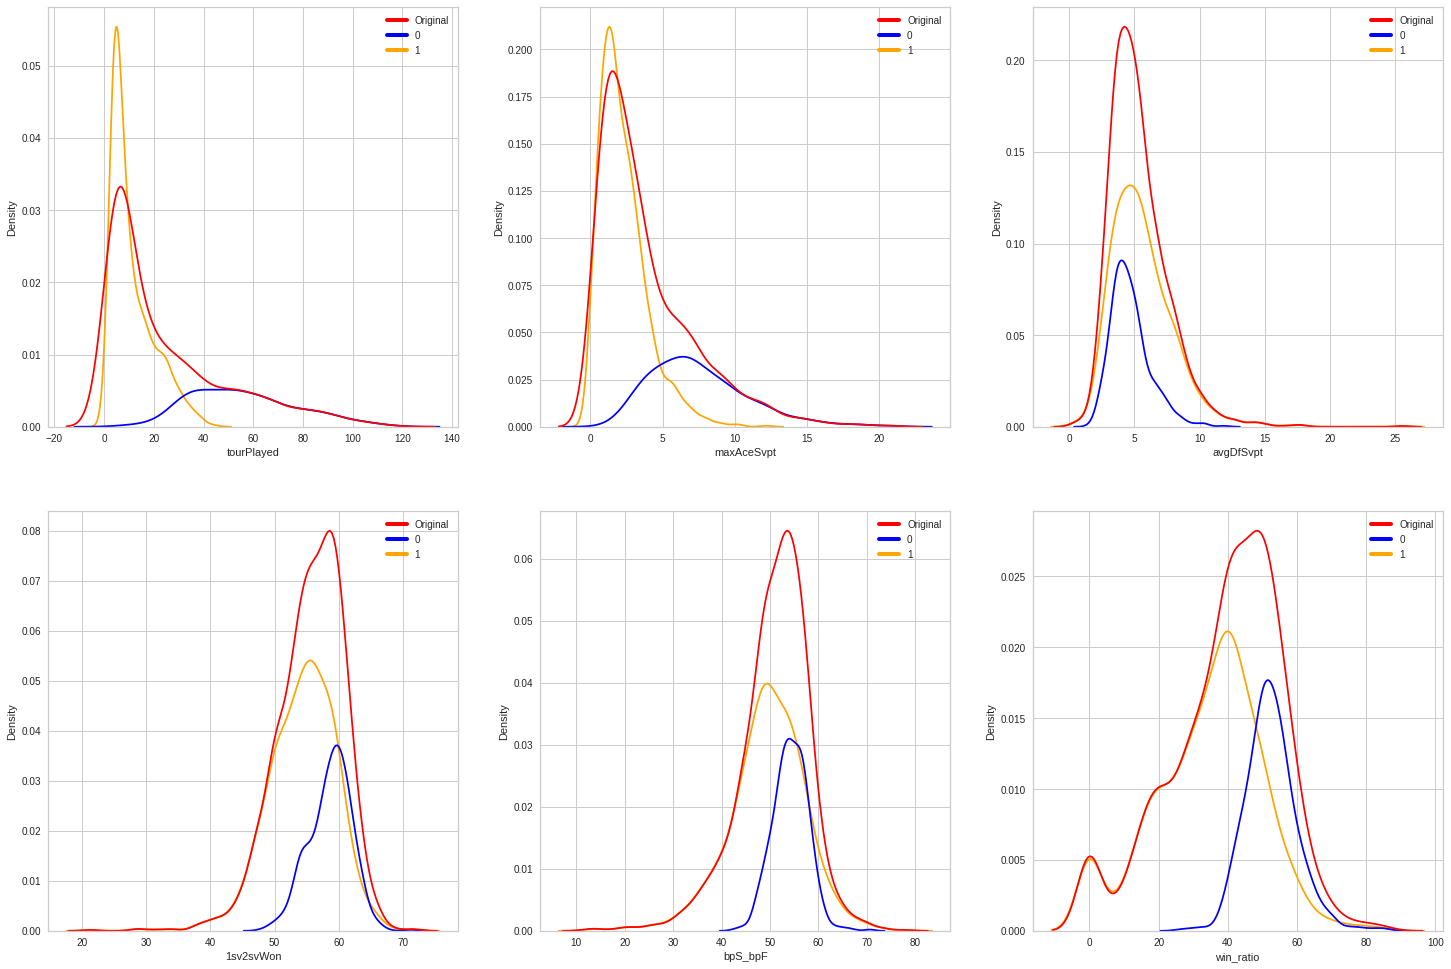

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 17))

plot_id = 0
for i in range(len(df_clst.columns[:-1])):
    p1 = sns.kdeplot(
            data=df_clst[:-1], 
            x=f"{df_clst.columns[i]}", 
            hue="kLabel",
            ax=axs[int(plot_id / 3)][plot_id % 3],
            palette=cluster_colors,
            legend=False
        ) 

    legend_elements = [
        Line2D([0], [0], color='red', lw=4, label='Original'),
        Line2D([0], [0], color=cluster_colors[0], lw=4, label='0'),
        Line2D([0], [0], color=cluster_colors[1], lw=4, label='1'),]
    p1.legend(handles=legend_elements)

    sns.kdeplot(
        data=df_clst[:-1], 
        x=f"{df_clst.columns[i]}", 
        ax=axs[int(plot_id / 3)][plot_id % 3],
        color="red"
    ) 
    plot_id += 1

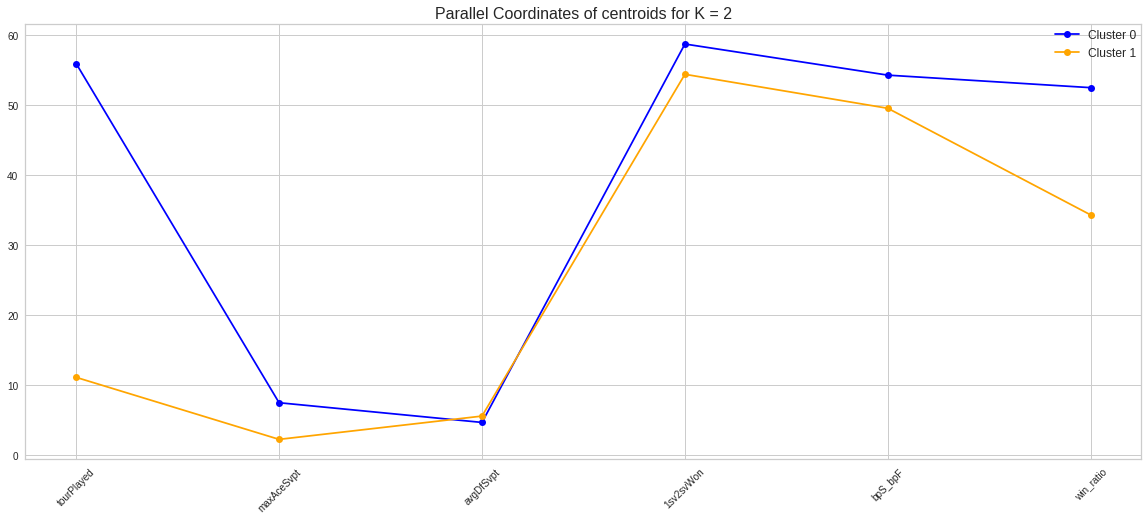

In [14]:
l = list(df_clst.columns[:-1])
N = len(df_clst.columns[:-1])
plt.figure(figsize=(20, 8))
for j in range(0, len(centroids)):
    plt.plot(centroids[j], marker='o', label='Cluster %s' % j, color=cluster_colors[j])
    
plt.xticks(range(0, len(df_clst.columns[:-1])), l, rotation=45)
plt.legend(fontsize=12, loc='upper right', borderaxespad=0.)
plt.title('Parallel Coordinates of centroids for K = 2', fontsize=16)

plt.show()

As we can see the most discriminative features seems to be the amount of tournaments played and the win ratio while it seems that `avgDfSvpt` does not separate in a good way the two clusters. This is also reflected in the following radar plot.

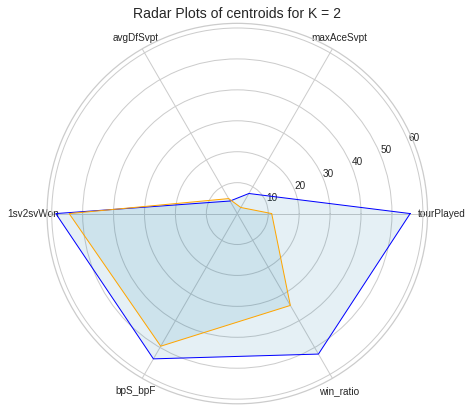

In [15]:
plt.figure(figsize=(15, 15))
for i in range(0, len(centroids)):
    angles = [n / float(N) * 2 * math.pi for n in range(N)]
    values = centroids[i].tolist()
    values += values[:1]
    angles += angles[:1]
    
    # Initialise the spider plot
    ax = plt.subplot(1,2,j+1,polar=True)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], l, size=10) 

    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid', color=cluster_colors[i])
 
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)
    ax.set_title('Radar Plots of centroids for K = 2', fontsize=14)

plt.show()

## Cluster understanding<a name="cluster-understanding"></a>

We use external attributes that we did not use in the clustering to get an insight on the meaning of the two clusters. The parallel coordinates plot already indicates that the first cluster represents the strongest players which have been consistent during the years (high number of tournaments played and win ratio as centroid) whereas the other cluster indicates players less consistent which have lost more. 

In [16]:
df_new_all['kLabel'] = df_clst['kLabel']

In [17]:
def plot_pie(size_type0_cl0, size_type1_cl0, size_type0_cl1, size_type1_cl1, color0, color1, label0, label1, title0, title1):
    fig = plt.figure(figsize=(10, 5)) 
    ax_dims = (1, 2)

    ax1 = plt.subplot2grid(ax_dims,(0,0))
    ax1.set_title(title0)
    labels = label0, label1
    sizes = [size_type0_cl0, size_type1_cl0]
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors = [color0, color1],
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1 = plt.subplot2grid(ax_dims, (0, 1))

    ax1.set_title(title1)
    sizes = [size_type0_cl1, size_type1_cl1]
    ax1.pie(sizes,labels=labels, autopct='%1.1f%%', colors = [color0, color1],
            shadow=True, startangle=90)
    ax1.axis('equal')  

    plt.show()

In [18]:
males_cl0 = df_new_all[(df_new_all.sex == 'm') & (df_new_all.kLabel == 0) ].shape[0]
females_cl0 = df_new_all[(df_new_all.sex == 'f') & (df_new_all.kLabel == 0) ].shape[0]

males_cl1 = df_new_all[(df_new_all.sex == 'm') & (df_new_all.kLabel == 1) ].shape[0]
females_cl1 = df_new_all[(df_new_all.sex == 'f') & (df_new_all.kLabel == 1) ].shape[0]

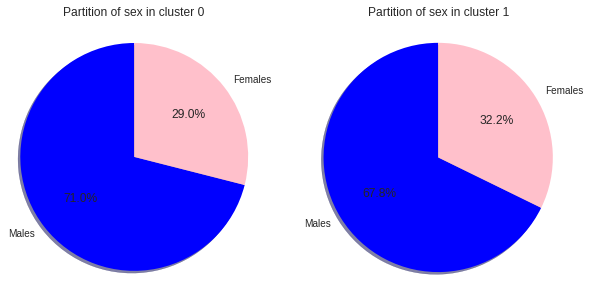

In [19]:
plot_pie(males_cl0, females_cl0, males_cl1, females_cl1, 'blue', 'pink', 'Males', 'Females', "Partition of sex in cluster 0", "Partition of sex in cluster 1")

In [20]:
right_hand_cl0 = df_new_all[(df_new_all.hand == 'R') & (df_new_all.kLabel == 0) ].shape[0]
left_hand_cl0 = df_new_all[(df_new_all.hand == 'L') & (df_new_all.kLabel == 0) ].shape[0]

right_hand_cl1 = df_new_all[(df_new_all.hand == 'R') & (df_new_all.kLabel == 1) ].shape[0]
left_hand_cl1 = df_new_all[(df_new_all.hand == 'L') & (df_new_all.kLabel == 1) ].shape[0]
print(left_hand_cl0)

64


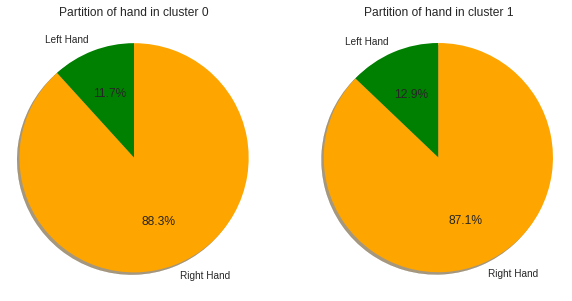

In [21]:
plot_pie(left_hand_cl0, right_hand_cl0, left_hand_cl1, right_hand_cl1, 'green', 'orange', 'Left Hand', 'Right Hand', "Partition of hand in cluster 0", "Partition of hand in cluster 1")

We have that in both clusters we have about the same quantity of male and female players. This is also true for the type of hand used.

<AxesSubplot:xlabel='kLabel', ylabel='win_ratio'>

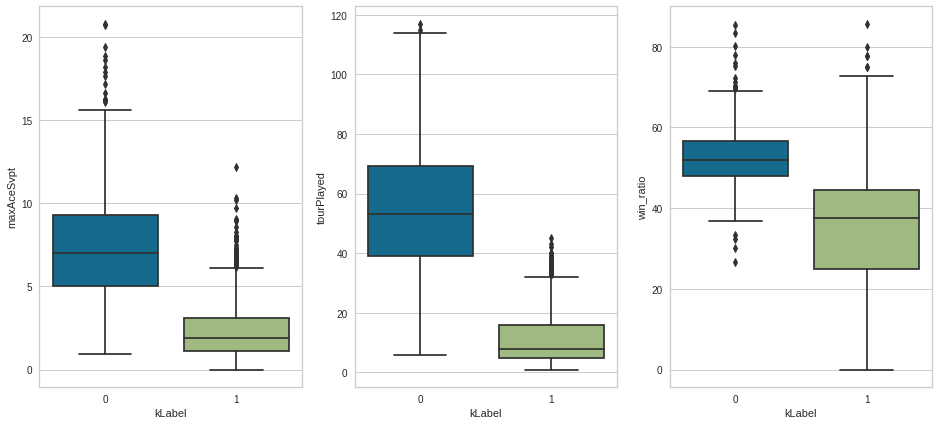

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.boxplot(x="kLabel", y='maxAceSvpt', ax=ax[0], data=df_new_all)
sns.boxplot(x="kLabel", y='tourPlayed', ax=ax[1], data=df_new_all)
sns.boxplot(x="kLabel", y='win_ratio', ax=ax[2], data=df_new_all)

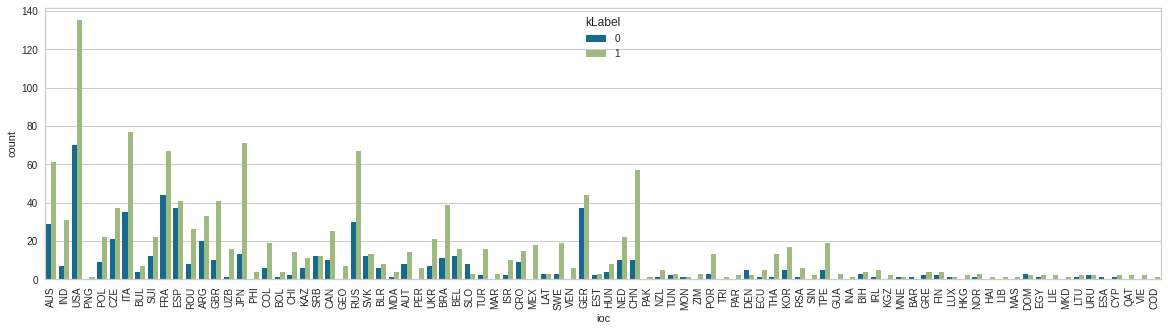

In [23]:
plt.figure(figsize=(20, 5))
p = sns.countplot(x="ioc", data=df_new_all, hue='kLabel')
p.tick_params(axis='x', rotation=90)

In [24]:
def plot_dist_clusters(df, attribute):
    fig, ax = plt.subplots()
    sns.kdeplot(x=attribute, data=df, hue='kLabel', multiple="layer", palette=['tab:blue', 'tab:red'])
    plt.show()

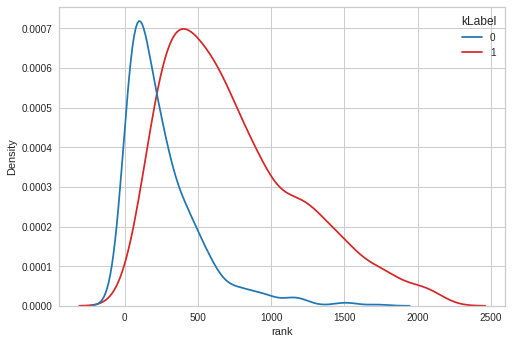

In [25]:
plot_dist_clusters(df_new_all, attribute='rank')

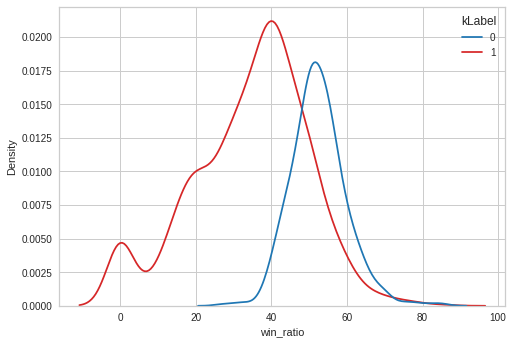

In [26]:
plot_dist_clusters(df_new_all, attribute='win_ratio')

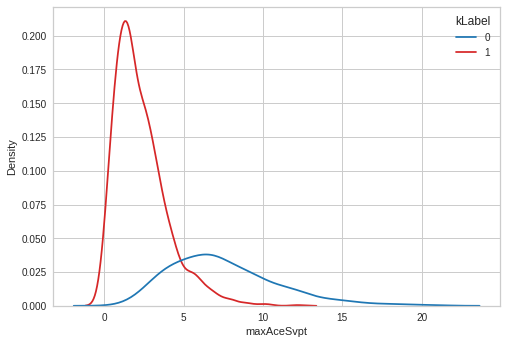

In [27]:
plot_dist_clusters(df_new_all, attribute='maxAceSvpt')

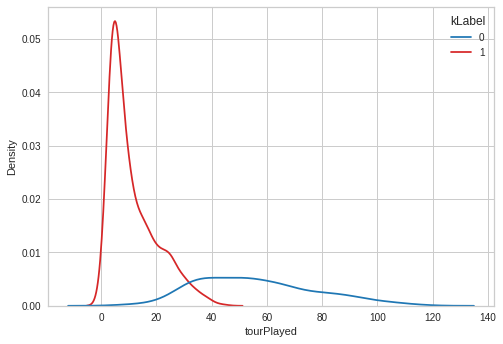

In [28]:
plot_dist_clusters(df_new_all, attribute='tourPlayed')

array([[<AxesSubplot:title={'center':'rank'}>,
        <AxesSubplot:title={'center':'ht'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'tourPlayed'}>,
        <AxesSubplot:title={'center':'maxAceSvpt'}>,
        <AxesSubplot:title={'center':'avgDfSvpt'}>],
       [<AxesSubplot:title={'center':'1sv2svWon'}>,
        <AxesSubplot:title={'center':'bpS_bpF'}>,
        <AxesSubplot:title={'center':'win_ratio'}>],
       [<AxesSubplot:title={'center':'kLabel'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

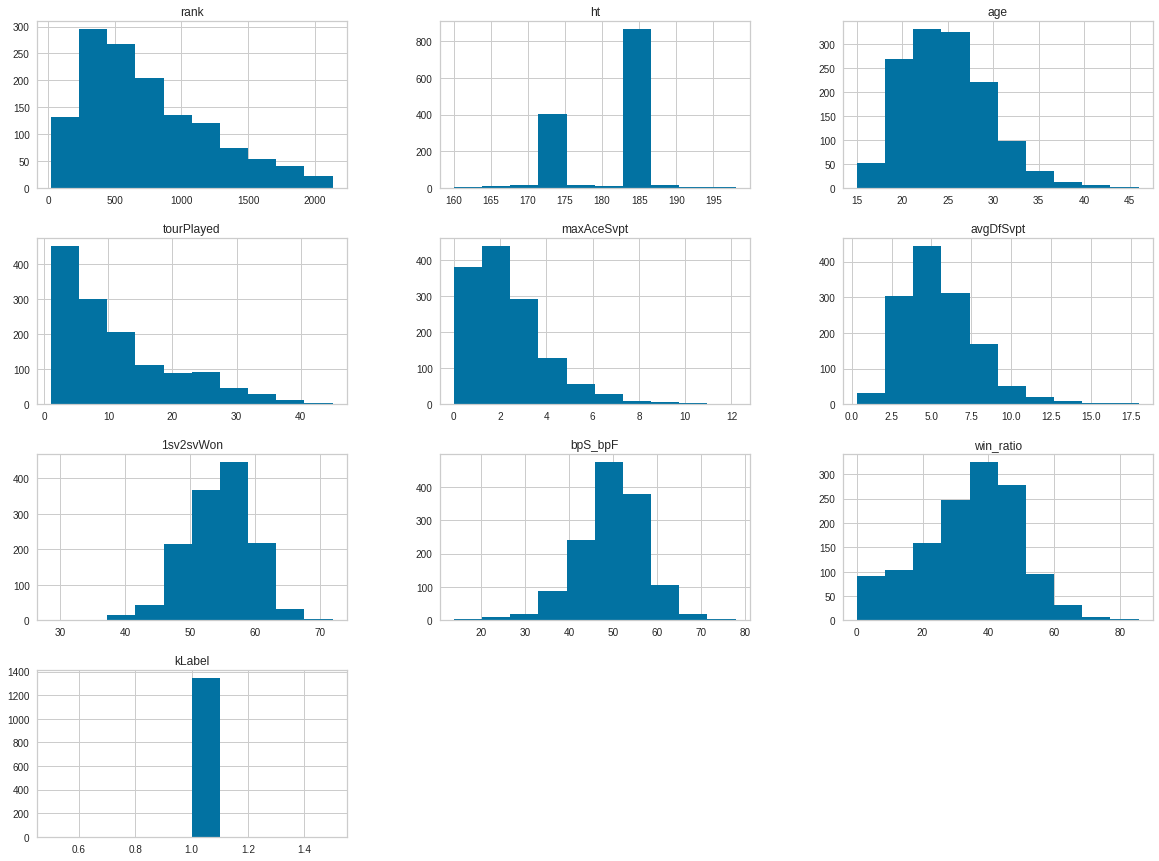

In [29]:
df_new_all[df_new_all.kLabel == 1].hist(figsize=(20,15))

## Hierarchical clustering<a name="hierarchical"></a>

Hierarchical clustering allows us to define a set of nested clusters that are organized like a hierarchical tree. Differently from K-Means we do not have to specify the amount of expected clusters.

In the following we will use an agglomerative based hierarchical clustering that is based on a bottom-up approach in which at the start there will be a cluster for each point and then at each step the two closest clusters will be merged.

To define inter-cluster similarity we will use the euclidean metric and the following methods:
- `Single` method corresponds to `MIN`, the proximity of two clusters is based on the two closest points inside the clusters.
- `Complete` method corresponds to `MAX`, the proximity of two clusters is based on the two most distant points inside the clusters.
- `Average` method corresponds to the `group average`, the proximity of two clusters is the average of pairwise proximity between points in the two clusters.
- `Ward` method in which the similarity of two clusters is based on the increase in squared error when two clusters are merged.

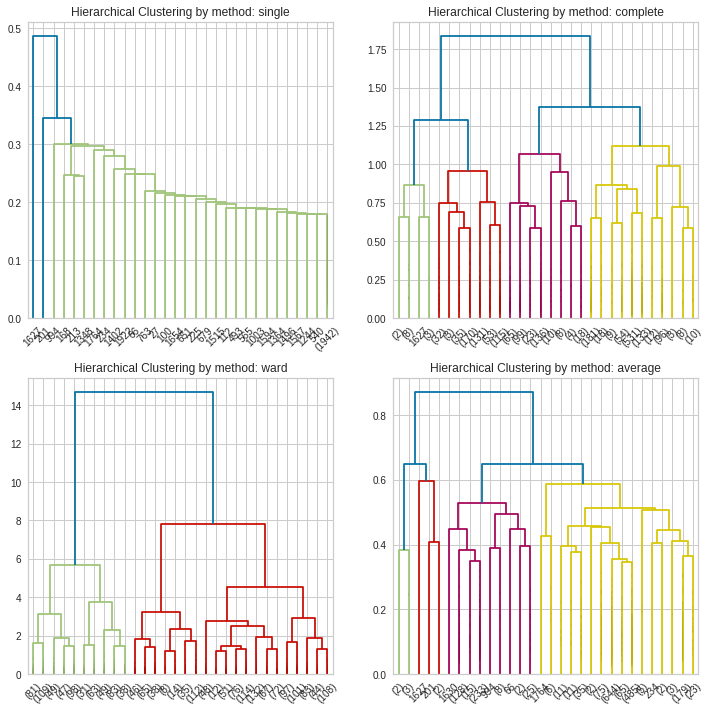

In [32]:
methods = ['single', 'complete', 'ward', 'average']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

i = 0
for method in methods:
    data_dist = pdist(df_normalized, metric='euclidean')
    data_link = linkage(data_dist, method=method, metric='euclidean')
    
    dendrogram(
        data_link, 
        truncate_mode='lastp', p=30, 
        ax=axs[int(i / 2)][i % 2], 
        show_contracted=True)
        
    axs[int(i / 2)][i % 2].set_title(f"Hierarchical Clustering by method: {methods[i]}")

    i += 1

plt.show()

It seems that the single method does not seem really meaningful as it gives us only a cluster. For the other methods we have that with the default cut-off a maximum of 5 clusters are found (with average method).

In [33]:
def metrics_info_agg(linkage_type, df):
    labels = []
    candidates = [2, 3, 4, 5]

    for i in candidates:
        cluster = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage=linkage_type)
        cluster.fit_predict(df_clst[indicators])
        labels.append(cluster.labels_) 

    sep = []
    sil = []
    cal_har = []
    for i in range(len(candidates)):
        sep.append(davies_bouldin_score(df, labels[i]))
        sil.append(silhouette_score(df, labels[i]))
        cal_har.append(calinski_harabasz_score(df, labels[i]))

    metrics = pd.DataFrame()
    metrics['Num clusters'] = candidates
    metrics['Davies_Bouldin'] = sep
    metrics['Silhouette'] = sil
    metrics['Calinski_Harabasz'] = cal_har
    
    return metrics

As with K-Means we try to understand what are the best number of clusters that we can use for complete, average and ward methods.

### Agglomerative clustering using complete method<a name="complete"></a>

In [34]:
complete_metrics = metrics_info_agg('complete', df_normalized)
complete_metrics

Num clusters  Davies_Bouldin  Silhouette  Calinski_Harabasz
0             2        0.781656    0.381738         565.983434
1             3        0.998066    0.230055         642.030328
2             4        1.903620    0.108074         492.927652
3             5        1.543121    0.179639         735.801296

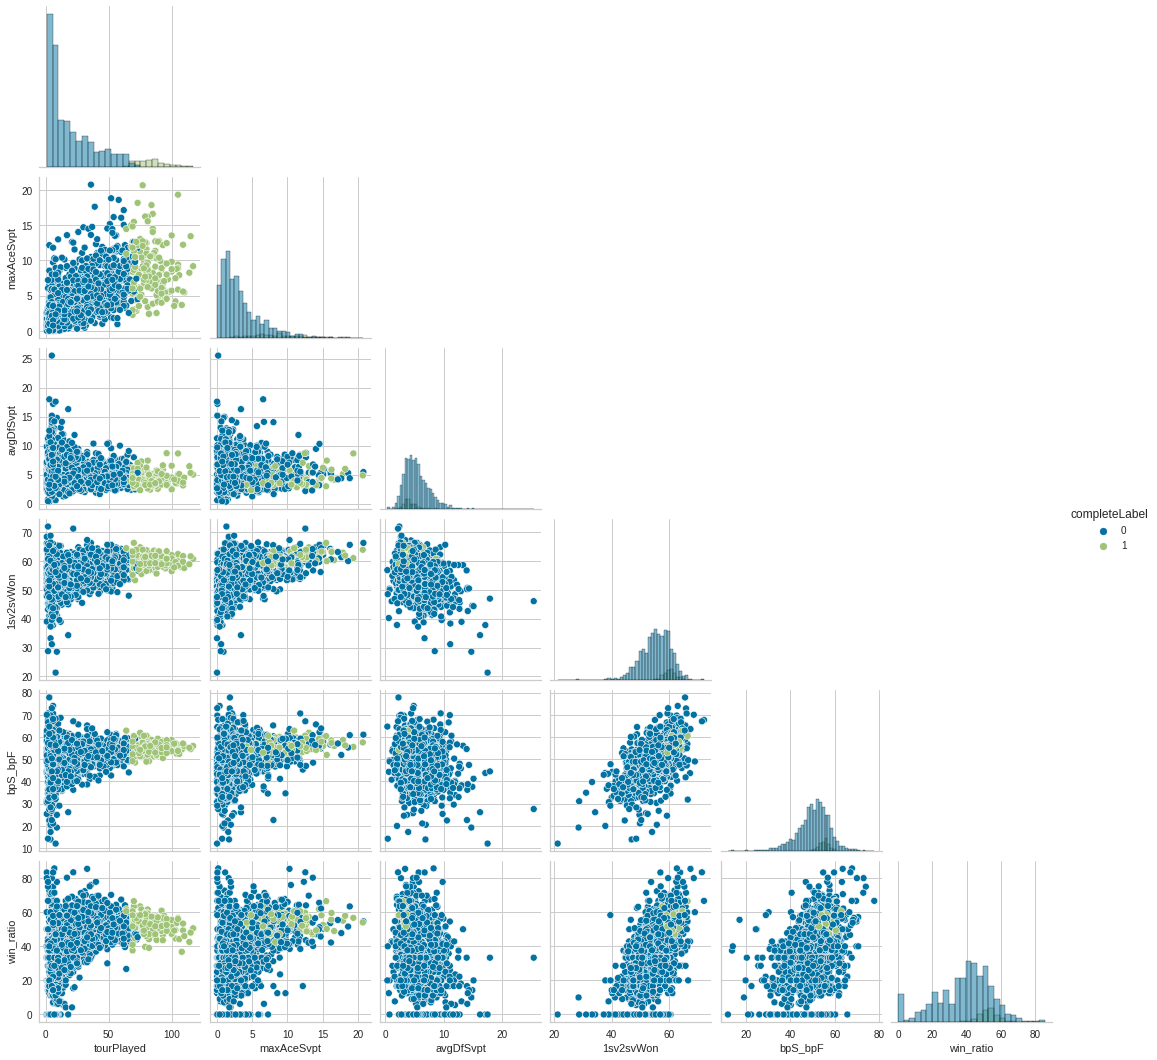

In [35]:
cluster_complete = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='complete')
cluster_complete.fit_predict(df_clst[indicators])
df_clst[f"completeLabel"] = cluster_complete.labels_
df_new_all['completeLabel'] = df_clst['completeLabel']

g = sns.pairplot(
    df_clst[indicators + ['completeLabel']], 
    hue="completeLabel", 
    corner=True, 
    diag_kind="hist")

### Agglomerative clustering using ward method<a name="ward"></a>

In [36]:
ward_metrics = metrics_info_agg('ward', df_normalized)
ward_metrics

Num clusters  Davies_Bouldin  Silhouette  Calinski_Harabasz
0             2        0.975927    0.381307        1255.158498
1             3        1.153554    0.281646        1104.161557
2             4        1.297994    0.211660         870.550209
3             5        1.710673    0.136171         762.060355

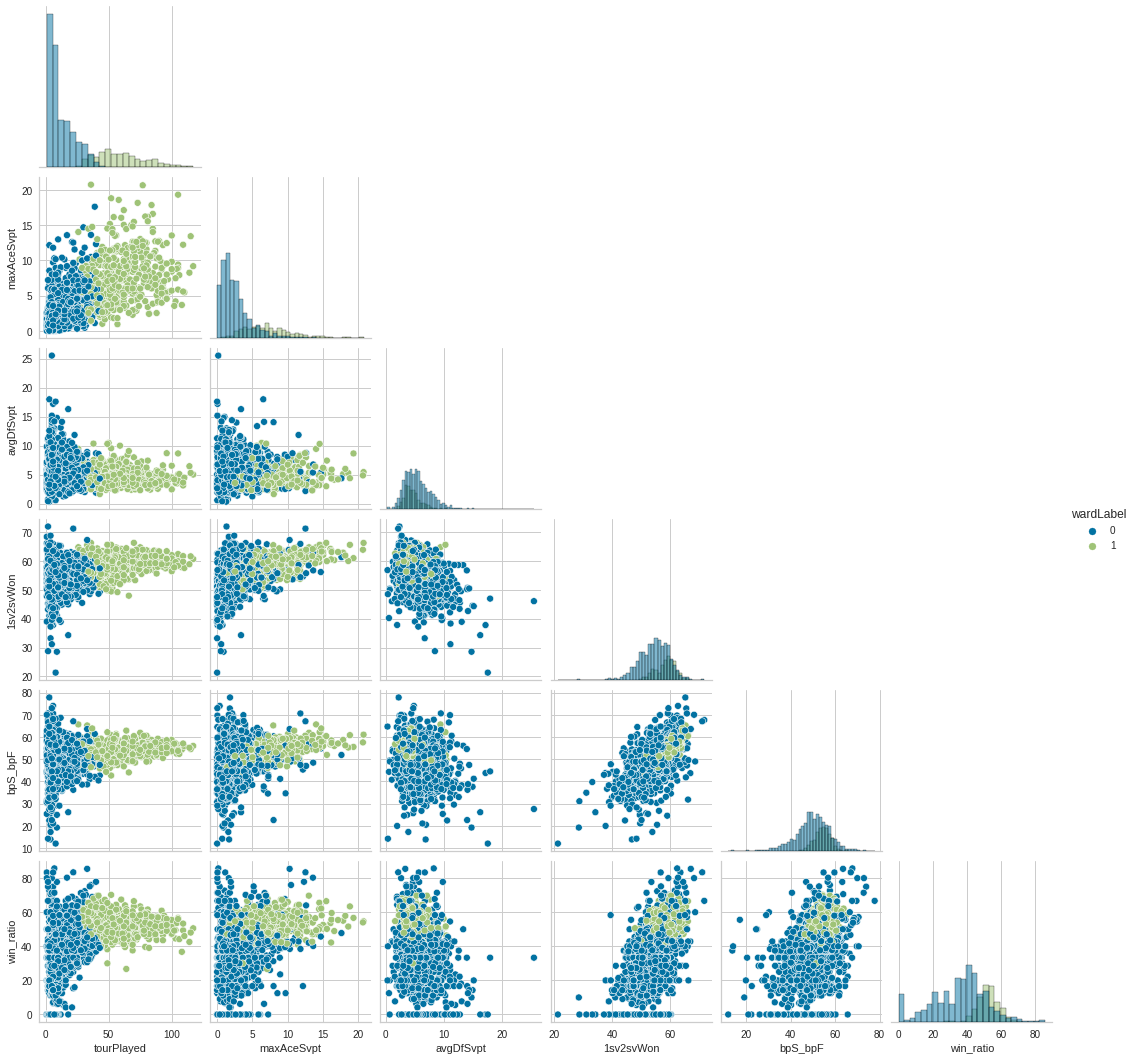

In [37]:
cluster_ward = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster_ward.fit_predict(df_clst[indicators])
df_clst[f"wardLabel"] = cluster_ward.labels_
df_new_all['wardLabel'] = df_clst['wardLabel']

g = sns.pairplot(
    df_clst[indicators + ['wardLabel']], 
    hue="wardLabel", 
    corner=True, 
    diag_kind="hist")

### Agglomerative clustering using average method<a name="average"></a>

In [38]:
average_metrics = metrics_info_agg('average', df_normalized)
average_metrics

Num clusters  Davies_Bouldin  Silhouette  Calinski_Harabasz
0             2        0.953092    0.384595        1209.706842
1             3        1.029500    0.369607         657.028434
2             4        1.033107    0.284873         602.856828
3             5        1.093277    0.277438         470.898938

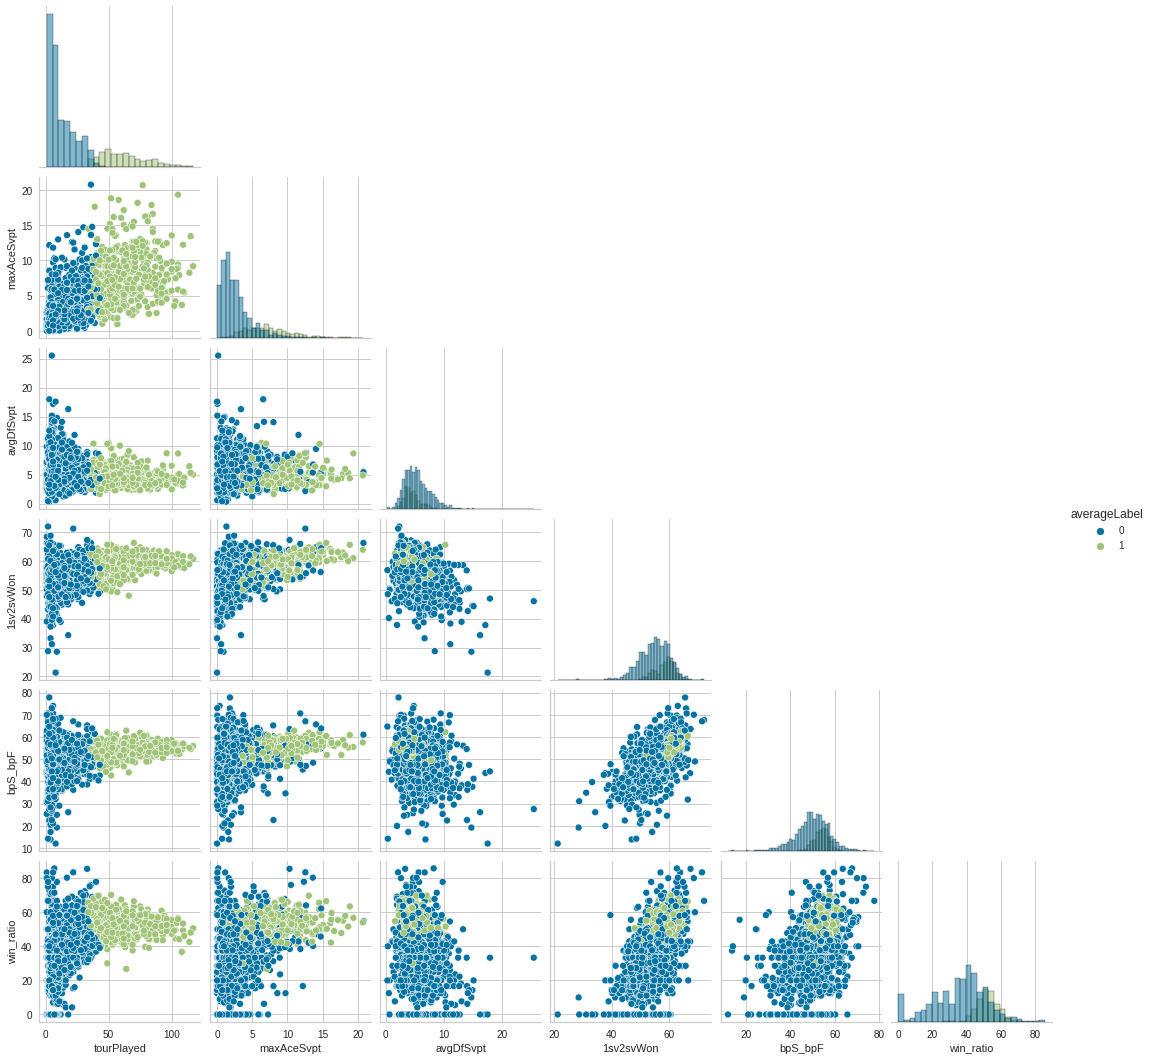

In [39]:
cluster_average = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
cluster_average.fit_predict(df_clst[indicators])
df_clst["averageLabel"] = cluster_average.labels_
df_new_all['averageLabel'] = df_clst['averageLabel']

g = sns.pairplot(
    df_clst[indicators + ['averageLabel']], 
    hue="averageLabel", 
    corner=True, 
    diag_kind="hist")

### Cluster understanding<a name="cluster-understanding-hiera"></a>

For all the three methods we get almost the same results with 2 clusters. Now we try to understand if we can get the same considerations as K-Means.

<AxesSubplot:xlabel='averageLabel', ylabel='count'>

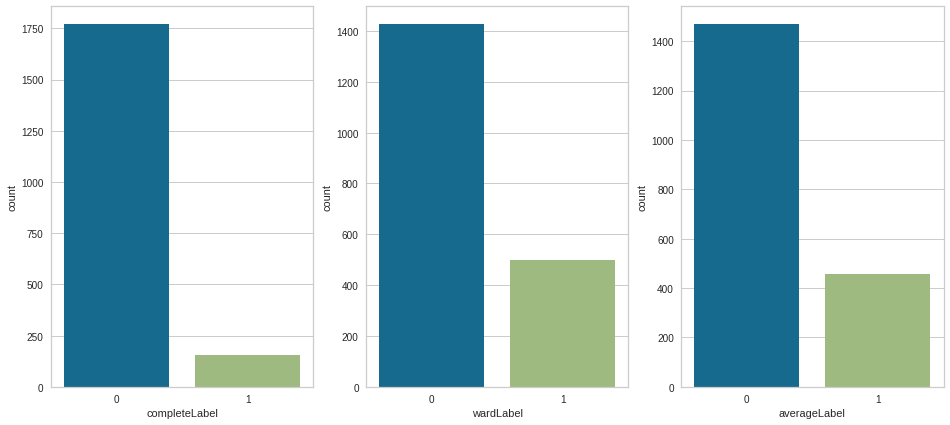

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.countplot(x="completeLabel", ax=ax[0], data=df_new_all)
sns.countplot(x="wardLabel", ax=ax[1], data=df_new_all)
sns.countplot(x="averageLabel", ax=ax[2], data=df_new_all)

We can see the ward method and average method are almost equal and differently than complete method they reduce a bit the unbalanceness.

<AxesSubplot:xlabel='sex', ylabel='count'>

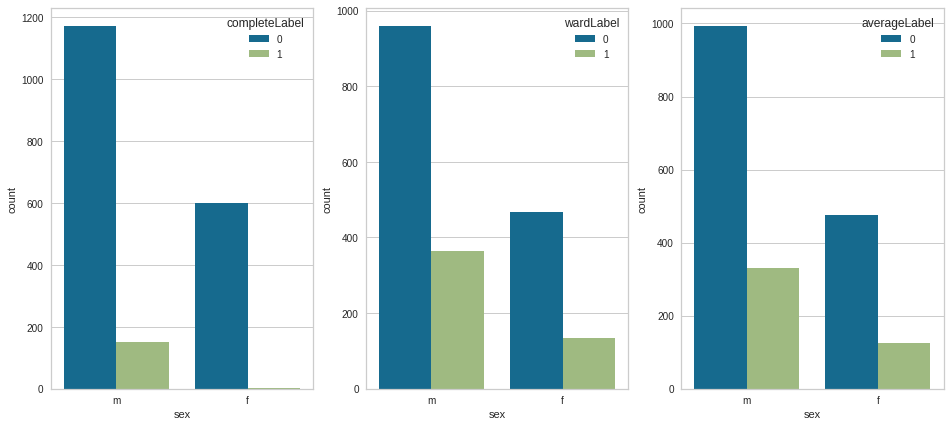

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.countplot(x="sex", ax=ax[0], data=df_new_all, hue='completeLabel')
sns.countplot(x="sex", ax=ax[1], data=df_new_all, hue='wardLabel')
sns.countplot(x="sex", ax=ax[2], data=df_new_all, hue='averageLabel')

<AxesSubplot:xlabel='hand', ylabel='count'>

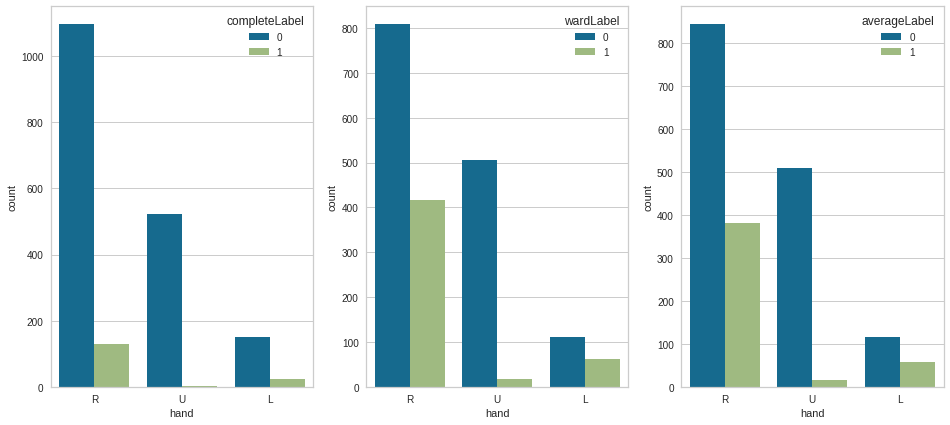

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.countplot(x="hand", ax=ax[0], data=df_new_all, hue='completeLabel')
sns.countplot(x="hand", ax=ax[1], data=df_new_all, hue='wardLabel')
sns.countplot(x="hand", ax=ax[2], data=df_new_all, hue='averageLabel')

<AxesSubplot:xlabel='averageLabel', ylabel='maxAceSvpt'>

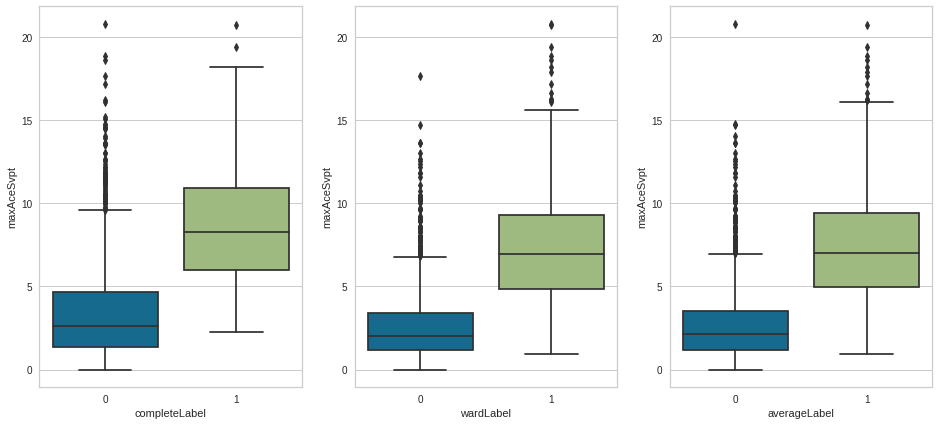

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.boxplot(x="completeLabel", y='maxAceSvpt', ax=ax[0], data=df_new_all)
sns.boxplot(x="wardLabel", y='maxAceSvpt', ax=ax[1], data=df_new_all)
sns.boxplot(x="averageLabel", y='maxAceSvpt', ax=ax[2], data=df_new_all)

<AxesSubplot:xlabel='averageLabel', ylabel='tourPlayed'>

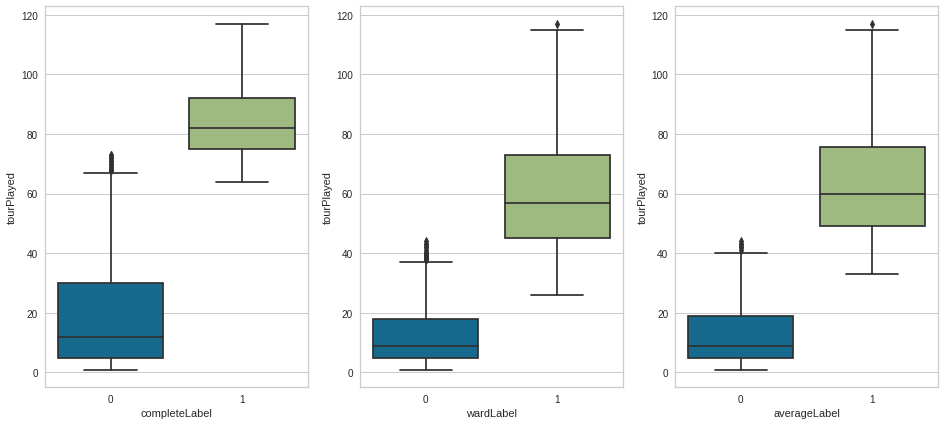

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.boxplot(x="completeLabel", y='tourPlayed', ax=ax[0], data=df_new_all)
sns.boxplot(x="wardLabel", y='tourPlayed', ax=ax[1], data=df_new_all)
sns.boxplot(x="averageLabel", y='tourPlayed', ax=ax[2], data=df_new_all)

Looking at the attribute tourPlayed the two clusters differs a lot, also there is a bit of difference when we consider the attributes avgDfSvpt and maxAceSvpt.

<AxesSubplot:xlabel='averageLabel', ylabel='avgDfSvpt'>

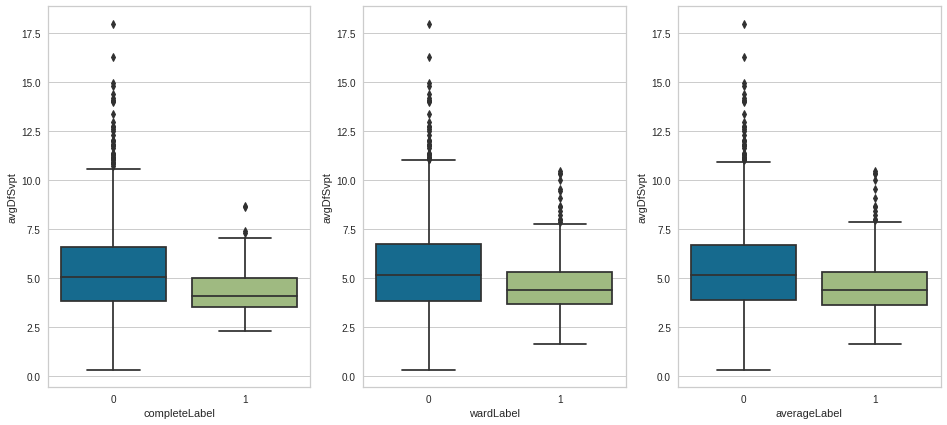

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 7))
sns.boxplot(x="completeLabel", y='avgDfSvpt', ax=ax[0], data=df_new_all)
sns.boxplot(x="wardLabel", y='avgDfSvpt', ax=ax[1], data=df_new_all)
sns.boxplot(x="averageLabel", y='avgDfSvpt', ax=ax[2], data=df_new_all)

<AxesSubplot:xlabel='count', ylabel='ioc'>

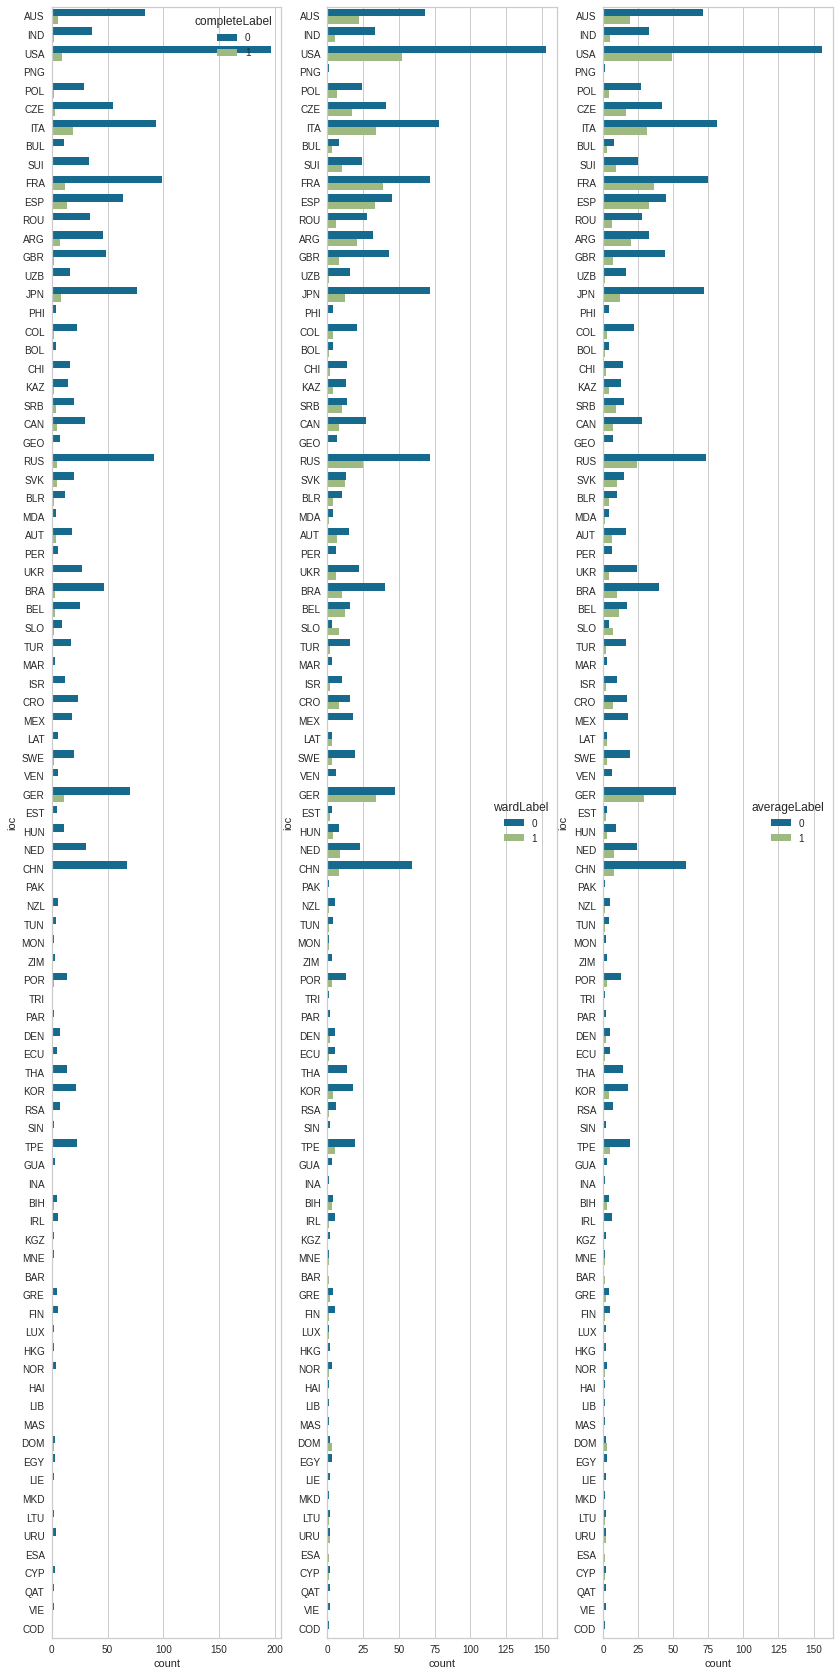

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 30))

sns.countplot(y="ioc", ax=ax[0], data=df_new_all, hue='completeLabel')
sns.countplot(y="ioc", ax=ax[1], data=df_new_all, hue='wardLabel')
sns.countplot(y="ioc", ax=ax[2], data=df_new_all, hue='averageLabel')

We can see that there are some countries (France, Spain and Germany) where there is an higher number of "top-tier" players w.r.t "low-middle" tier players.

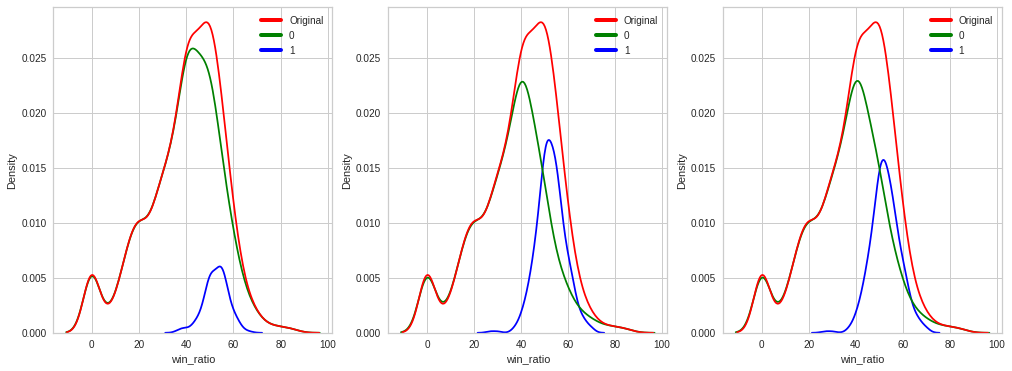

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 6))

i = 0
for label in ['completeLabel', 'wardLabel', 'averageLabel']:
    p1 = sns.kdeplot(
        data=df_clst[indicators + [label]], 
        x=df_clst['win_ratio'], 
        hue=label,
        ax=axs[i],
        palette=['green', 'blue'],
        legend=False
    ) 
    legend_elements = [
        Line2D([0], [0], color='red', lw=4, label='Original'),
        Line2D([0], [0], color='green', lw=4, label='0'),
        Line2D([0], [0], color='blue', lw=4, label='1'),]
    p1.legend(handles=legend_elements)
    sns.kdeplot(
        data=df_clst[indicators + [label]], 
        x=df_clst['win_ratio'], 
        ax=axs[i],
        color="red"
    ) 

    i += 1

df_clst.drop(labels=['completeLabel','wardLabel', 'averageLabel', 'kLabel'], axis=1, inplace=True) #clean df from the labels used

## Density Based clustering<a name="db-clustering"></a>

Next we focus on density based clustering, we will use the DBSCAN algorithm that considers clusters as dense region of points that are separated by lower or higher density regions. DBSCAN works well when clusters have different shapes and/or may be overlapping.

We compute the distances between the points using the euclidean metric, these values will be used in the knee method to establish which are the best parameters for the algorithm.

In [48]:
dist = pdist(df_normalized, 'euclidean') #pair wise distance
dist = squareform(dist) #distance matrix given the vector dist

In fact, in order to have similar densities inside the clusters we search for the k-th neighbour which is more distant from the others, which means that from that point there is noise, plotting the distances for the k-th neighbour when we choose the right eps by observing a great increase in distance.

In [49]:
def knee_method(k):
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
    plt.ylabel('dist from %sth neighbor' % k)
    plt.xlabel('sorted distances')
    plt.tick_params(axis='both', which='major')
    plt.show()

The algorithm takes as parameters `eps` which is the radius of the points to be considered and `min_samples` which is the minimum number of points to be considered. We perform a grid search to find the best values for these parameters. We first try the knee method with k=4 to find an optimal eps and try the algorithm.

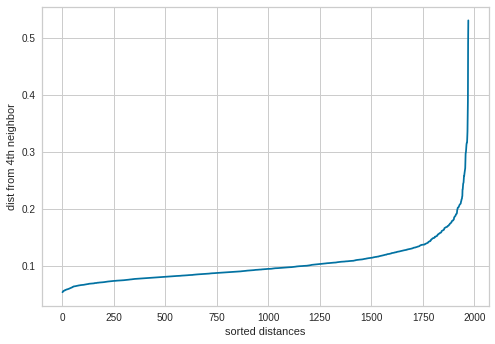

In [50]:
knee_method(4)

In [51]:
dbscan = DBSCAN(eps=0.18, min_samples=4)
dbscan.fit(df_normalized)

DBSCAN(eps=0.18, min_samples=4)

We can observe that DBSCAN produced one cluster of 1939 points and considered the other 34 points as noise, since we suspect that the possible clusters are two and not just one we keep search for a better result.

In [52]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0]), array([  32, 1939]))

In [53]:
df_clst['db_kLabel'] = dbscan.labels_ 

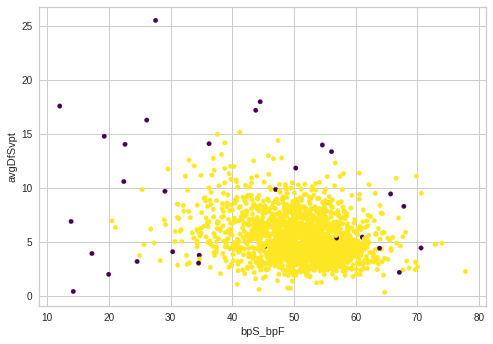

In [54]:
plt.scatter(df_clst['bpS_bpF'], df_clst['avgDfSvpt'], c=dbscan.labels_, cmap="viridis", s=20)
plt.tick_params(axis='both', which='major')
plt.xlabel("bpS_bpF")
plt.ylabel("avgDfSvpt")
plt.show()

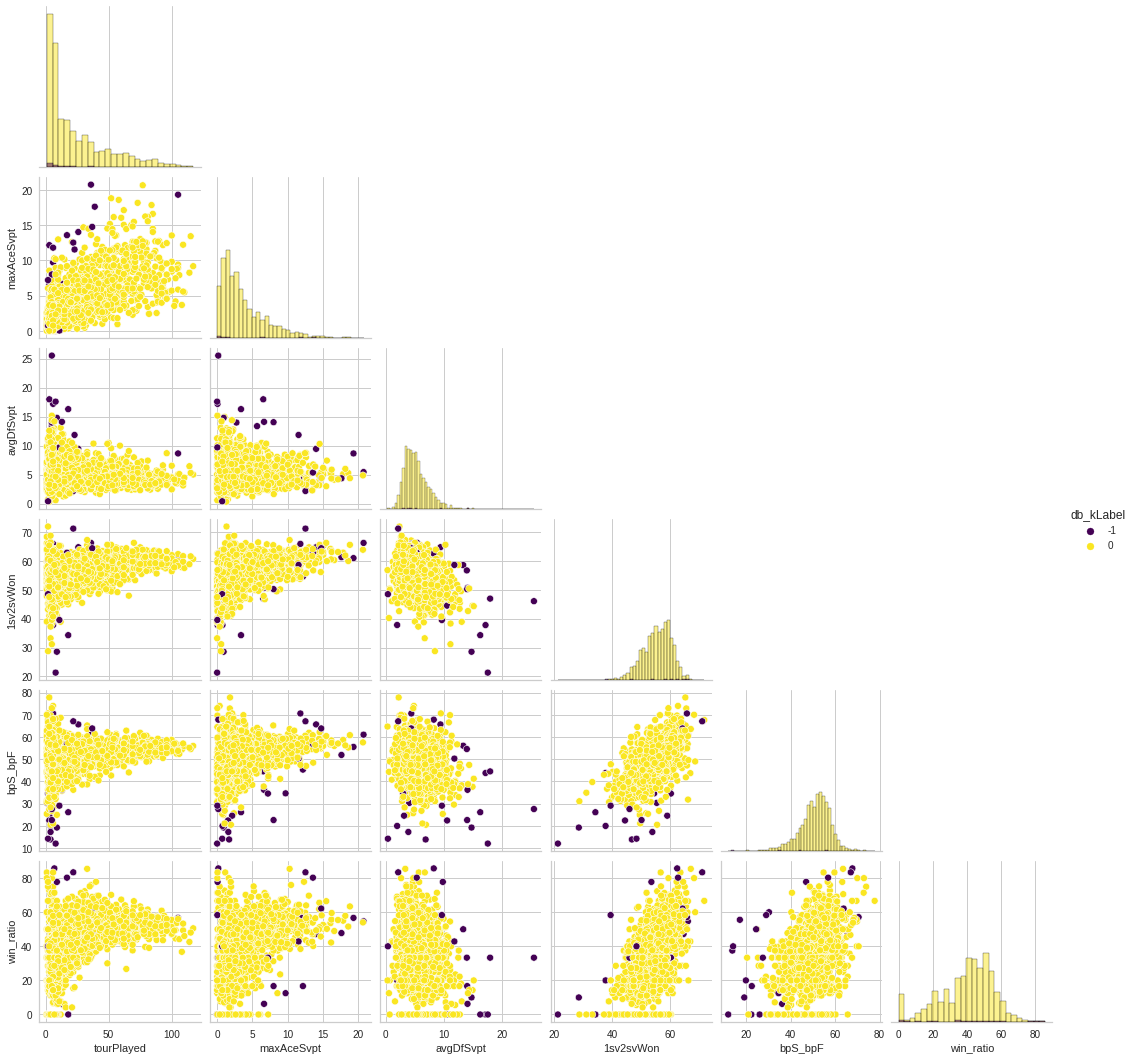

In [55]:
g = sns.pairplot(
    df_clst, 
    hue="db_kLabel", 
    corner=True, 
    diag_kind="hist",
    palette=['#440154', '#fae622'])

g.hue_vals = [0, 1]

plt.show()

We try a more elaborate search by using the mean noise points distance (epsilon) and the number of clusters (N) as metric, in this way fixing N we can search for the best parameters which yield the maximum distance from the noise points.

In [56]:
from sklearn.neighbors import NearestNeighbors 

In [57]:
eps_to_test = [round(eps,2) for eps in np.arange(0.05, 0.2, 0.01)]
min_samples_to_test = range(2, 20, 1)

print("EPS:", eps_to_test)
print("MIN_SAMPLES:", list(min_samples_to_test))

EPS: [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2]
MIN_SAMPLES: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [58]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric 
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighbours = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighbours.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric 
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log 
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [59]:
# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [60]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, df_normalized, iter_)
        
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric

ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.05 and min_samples =   2 | 0.099  125
  2 | Tested with eps = 0.05 and min_samples =   3 | 0.096   27
  3 | Tested with eps = 0.05 and min_samples =   4 | 0.095    9
  4 | Tested with eps = 0.05 and min_samples =   5 | 0.094    0
  5 | Tested with eps = 0.05 and min_samples =   6 | 0.094    0
  6 | Tested with eps = 0.05 and min_samples =   7 | 0.094    0
  7 | Tested with eps = 0.05 and min_samples =   8 | 0.094    0
  8 | Tested with eps = 0.05 and min_samples =   9 | 0.094    0
  9 | Tested with eps = 0.05 and min_samples =  10 | 0.094    0
 10 | Tested with eps = 0.05 and min_samples =  11 | 0.094    0
 11 | Tested with eps = 0.05 and min_samples =  12 | 0.094    0
 12 | Tested with eps = 0.05 and min_samples =  13 | 0.094    0
 13 | Tested with eps = 0.05 and min_samples =  14 | 0.094    0
 14 | Tested with eps = 0.05 and min

129 | Tested with eps = 0.12 and min_samples =   4 | 0.176    5
130 | Tested with eps = 0.12 and min_samples =   5 | 0.169    2
131 | Tested with eps = 0.12 and min_samples =   6 | 0.166    2
132 | Tested with eps = 0.12 and min_samples =   7 | 0.162    1
133 | Tested with eps = 0.12 and min_samples =   8 | 0.158    1
134 | Tested with eps = 0.12 and min_samples =   9 | 0.154    2
135 | Tested with eps = 0.12 and min_samples =  10 | 0.149    1
136 | Tested with eps = 0.12 and min_samples =  11 | 0.147    1
137 | Tested with eps = 0.12 and min_samples =  12 | 0.145    1
138 | Tested with eps = 0.12 and min_samples =  13 | 0.144    1
139 | Tested with eps = 0.12 and min_samples =  14 |  0.14    1
140 | Tested with eps = 0.12 and min_samples =  15 | 0.138    1
141 | Tested with eps = 0.12 and min_samples =  16 | 0.137    1
142 | Tested with eps = 0.12 and min_samples =  17 | 0.135    1
143 | Tested with eps = 0.12 and min_samples =  18 | 0.133    1
144 | Tested with eps = 0.12 and min_sam

259 | Tested with eps = 0.19 and min_samples =   8 | 0.267    1
260 | Tested with eps = 0.19 and min_samples =   9 | 0.267    1
261 | Tested with eps = 0.19 and min_samples =  10 | 0.261    1
262 | Tested with eps = 0.19 and min_samples =  11 | 0.255    1
263 | Tested with eps = 0.19 and min_samples =  12 | 0.247    1
264 | Tested with eps = 0.19 and min_samples =  13 | 0.245    1
265 | Tested with eps = 0.19 and min_samples =  14 | 0.245    1
266 | Tested with eps = 0.19 and min_samples =  15 | 0.244    1
267 | Tested with eps = 0.19 and min_samples =  16 | 0.236    1
268 | Tested with eps = 0.19 and min_samples =  17 | 0.234    1
269 | Tested with eps = 0.19 and min_samples =  18 | 0.234    1
270 | Tested with eps = 0.19 and min_samples =  19 |  0.23    1
271 | Tested with eps = 0.2 and min_samples =   2 | 0.307    1
272 | Tested with eps = 0.2 and min_samples =   3 | 0.307    1
273 | Tested with eps = 0.2 and min_samples =   4 | 0.305    1
274 | Tested with eps = 0.2 and min_samples

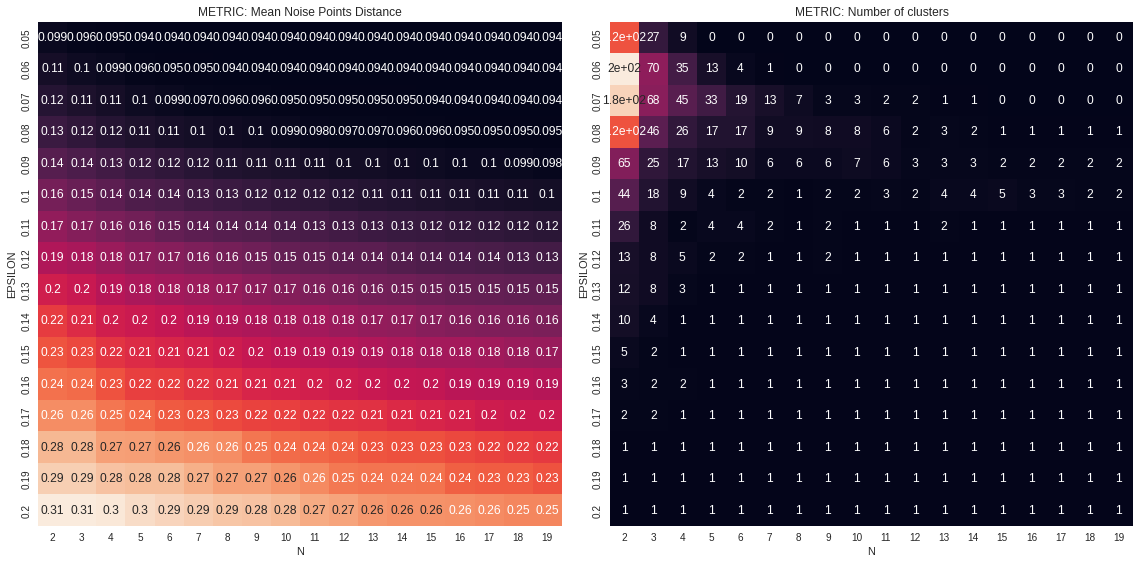

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [62]:
dbscan = DBSCAN(eps=0.17, min_samples=3)
dbscan.fit(df_normalized)

DBSCAN(eps=0.17, min_samples=3)

In [63]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1]), array([  37, 1931,    3]))

In [64]:
df_clst['db_kLabel'] = dbscan.labels_ 

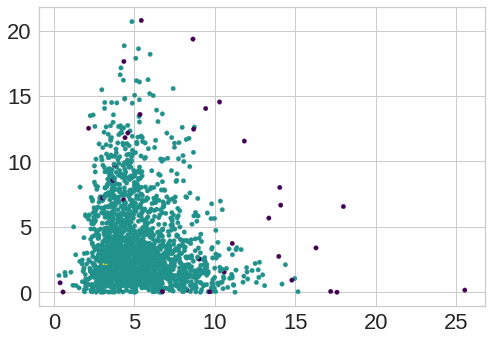

In [65]:
plt.scatter(df_clst['avgDfSvpt'], df_clst['maxAceSvpt'], c=dbscan.labels_, cmap="viridis", s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

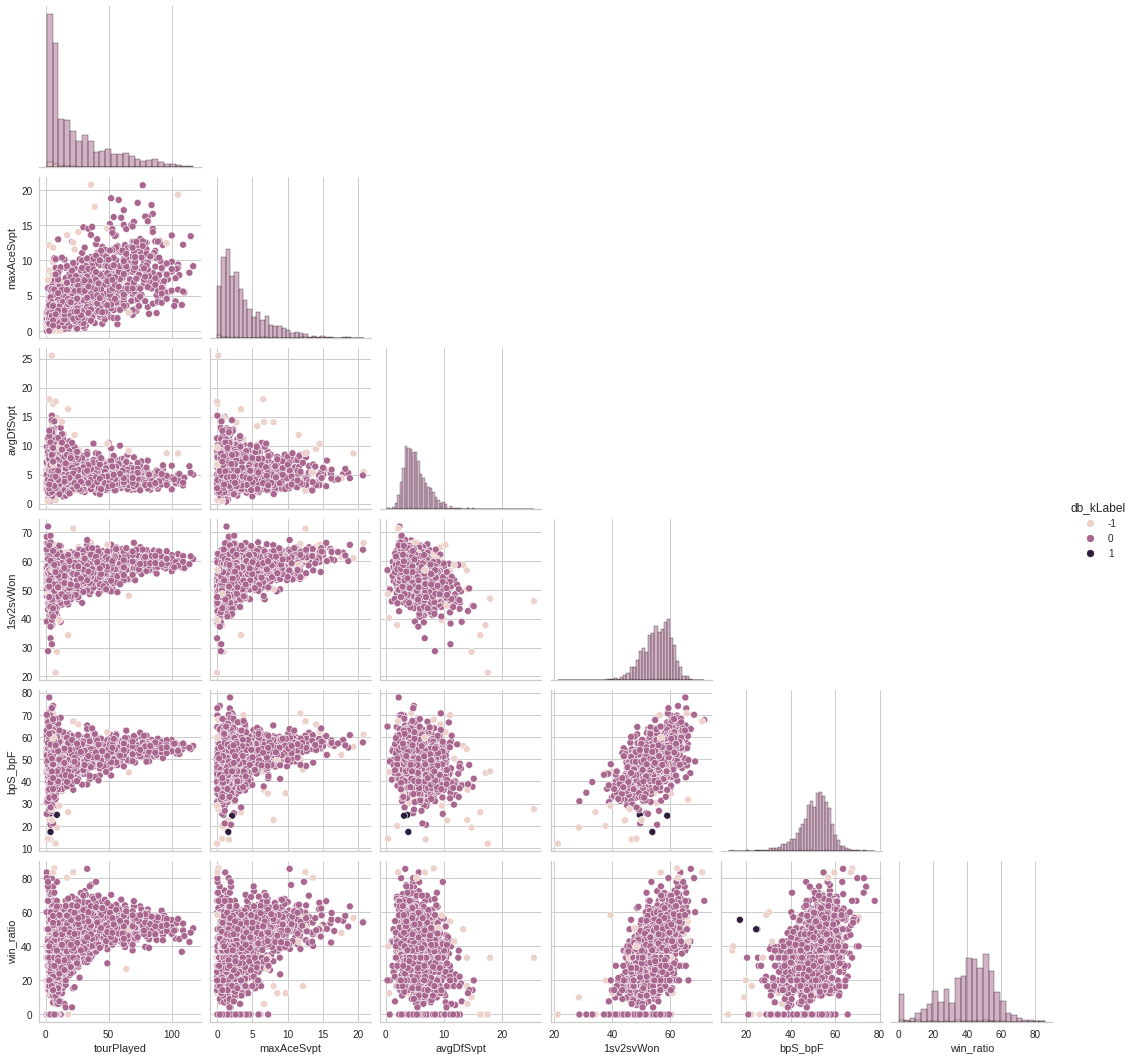

In [66]:
#sns.color_palette("Set2")
g = sns.pairplot(
    df_clst, 
    hue="db_kLabel", 
    corner=True, 
    diag_kind="hist")

g.hue_vals = [0, 1]

plt.show()

In [67]:
df_clst.drop(labels="db_kLabel", axis=1, inplace=True)

## Additional clustering algorithms considered<a name="additional-algos"></a>

In [68]:
df_normalized_list = df_normalized.tolist()

### X-Means<a name="xmeans"></a>

X-Means clustering algorithm extends K-Means by trying to automatically determine the number of clusters based on BIC score as splitting criterion.

We didn't get meaningful results by using this algorithm because almost all the clusters that were found are overlapping.

Total WCE: 71.8772349906489
Number of clusters: 10


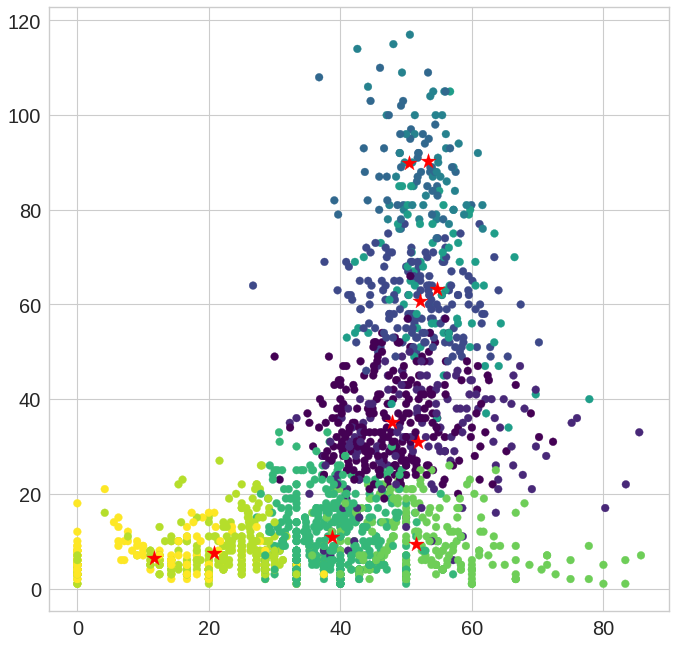

In [69]:
#prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will start analysis
amount_initial_centers = 2
initial_centers = kmeans_plusplus_initializer(df_normalized_list, amount_initial_centers).initialize()
 
# Create instance of X-Means algorithm. The algorithm will start analysis from 2 clusters, the maximum
# number of clusters that can be allocated is 30.
xmeans_instance = xmeans(df_normalized_list, initial_centers, 30)
xmeans_instance.process()
 
# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters()
centers = xmeans_instance.get_centers()
 
# Print total sum of metric errors
print("Total WCE:", xmeans_instance.get_total_wce())
 
print(f"Number of clusters: {len(clusters)}")
#Plot the results
labels = np.ones(df_normalized.shape[0])
for k in range(len(xmeans_instance._xmeans__clusters)):
    labels[xmeans_instance._xmeans__clusters[k]] = k+1

df_clst['Label'] = labels    
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_clst['win_ratio'], df_clst['tourPlayed'], c=labels, cmap="viridis")
centers = np.array(xmeans_instance._xmeans__centers)
centers = minmax_scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers, columns=df_clst.columns[:6].tolist())
plt.scatter(df_centers['win_ratio'],df_centers['tourPlayed'],s=200, marker='*',c='red')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

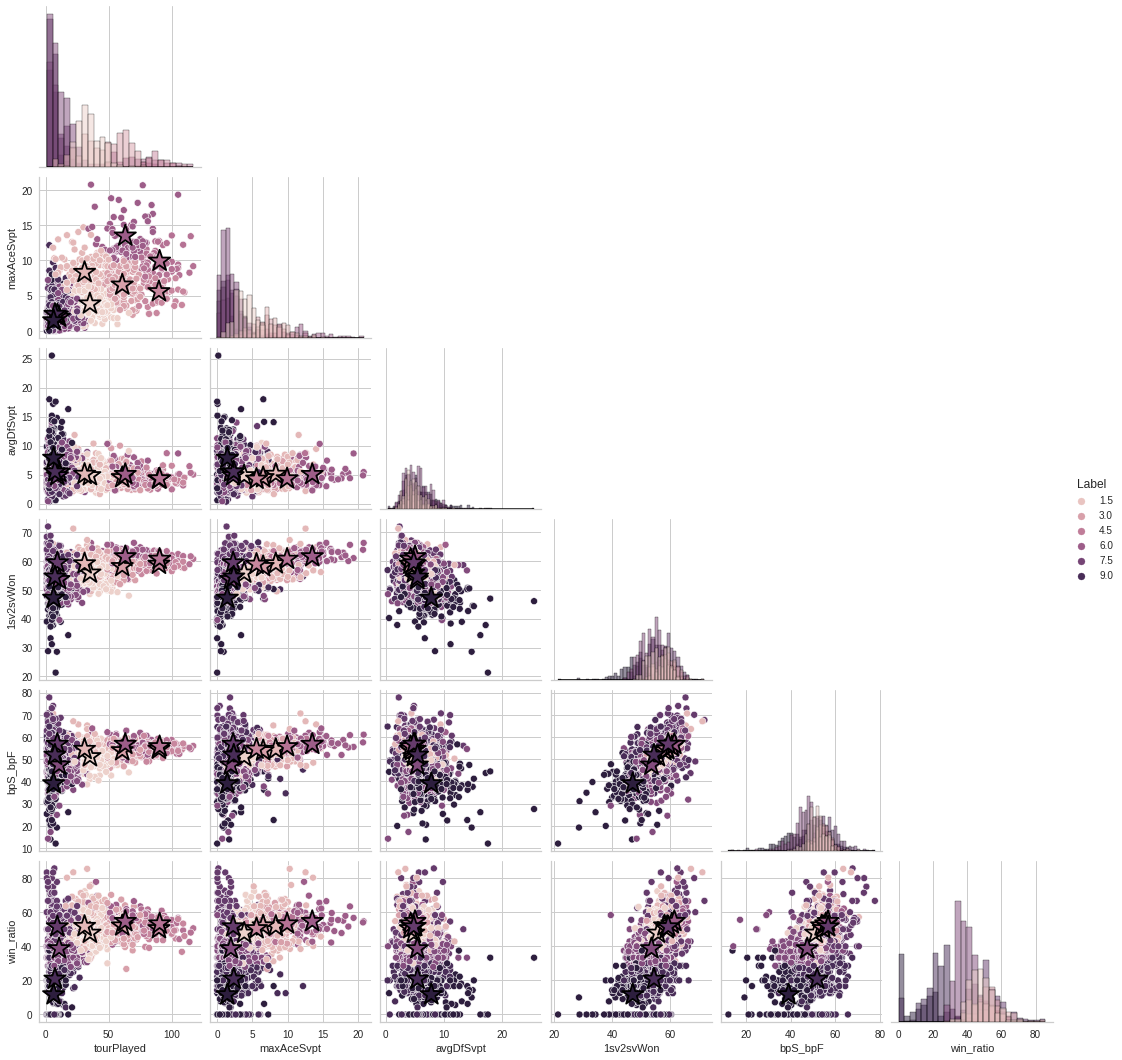

In [70]:
df_centroid = pd.DataFrame(centers, columns=df_clst.columns[:-1])
df_centroid['Label'] = list(range(0,len(clusters)))
sns.color_palette()
g = sns.pairplot(
    df_clst, 
    hue="Label", 
    corner=True, 
    diag_kind="hist",)


g.data = df_centroid
g.hue_vals = list(range(0,len(clusters)))

g.map_offdiag(sns.scatterplot, s=500, marker="*", edgecolor="black")

plt.show()

### G-Means<a name="gmeans"></a>

G-means is also an extension of K-Means and similar to X-Means starts with a small number of centers (by default one), and grows the number of centers by performing splitting that is based on the Anderson-Darling statistical test.

This algorithm performed worse than X-Means because it found even more clusters that resulted to be overlapping.

Total WCE: 27.16547658089091
Number of clusters: 92


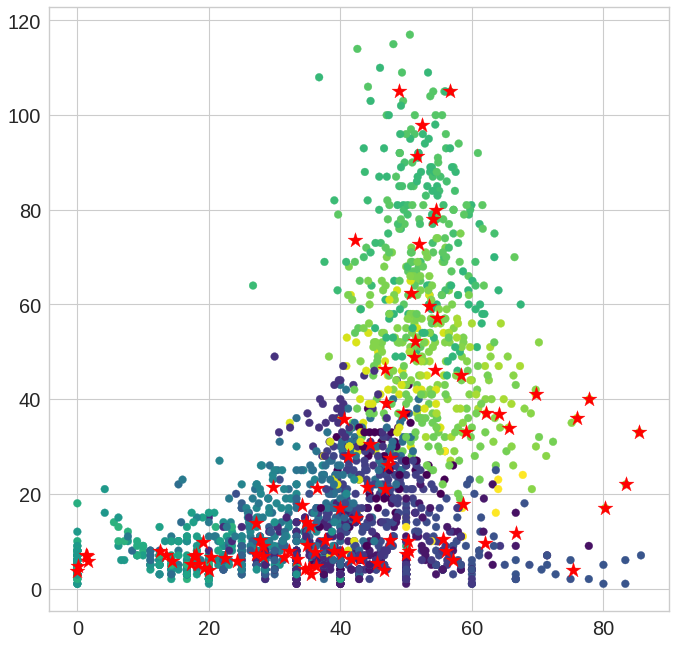

In [71]:
# Create instance of G-Means algorithm. By default the algorithm starts search from a single cluster.
gmeans_instance = gmeans(df_normalized_list).process()
 
# Extract clustering results: clusters and their centers
clusters = gmeans_instance.get_clusters()
centers = gmeans_instance.get_centers()

#Plot the results
labels = np.ones(df_normalized.shape[0])
for k in range(len(gmeans_instance._gmeans__clusters)):
    labels[gmeans_instance._gmeans__clusters[k]] = k+1

# Print total sum of metric errors
print("Total WCE:", gmeans_instance.get_total_wce())

print(f"Number of clusters: {len(clusters)}")
df_clst['Label'] = labels    
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_clst['win_ratio'], df_clst['tourPlayed'], c=labels, cmap="viridis")
centers = np.array(gmeans_instance._gmeans__centers)
centers = minmax_scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers, columns=df_clst.columns[:6].tolist())
plt.scatter(df_centers['win_ratio'],df_centers['tourPlayed'],s=200, marker='*',c='red')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

### Fuzzy clustering<a name="fuzzy-clustering"></a>

As the last algorithm we decided to use Fuzzy C-Means. In general, Fuzzy clustering is a form of clustering in which each data point can belong to more than one cluster.

Fuzzy C-Means algorithm uses two general formulas for cluster analysis. The first is to updated membership of each point, the second formula is used to update centers in line with obtained centers. With this algorithm we have to specify the number of expected clusters and to do so we used K-Means++.

Number of clusters: 2


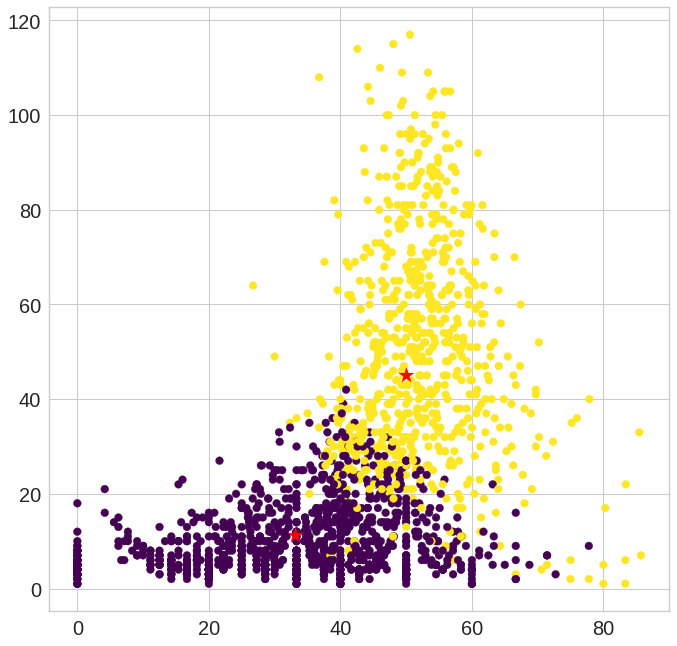

In [72]:
# initialize
initial_centers = kmeans_plusplus_initializer(df_normalized_list, 2, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
 
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(df_normalized_list, initial_centers)
 
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

print(f"Number of clusters: {len(clusters)}")
#Plot the results
labels = np.ones(df_normalized.shape[0])
for k in range(len(fcm_instance._fcm__clusters)):
    labels[fcm_instance._fcm__clusters[k]] = k+1

df_clst['Label'] = labels    
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(df_clst['win_ratio'], df_clst['tourPlayed'], c=labels, cmap="viridis")
centers = np.array(fcm_instance._fcm__centers)
centers = minmax_scaler.inverse_transform(centers)
df_centers = pd.DataFrame(centers, columns=df_clst.columns[:-1])
plt.scatter(df_centers['win_ratio'],df_centers['tourPlayed'],s=200, marker='*',c='red')
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()

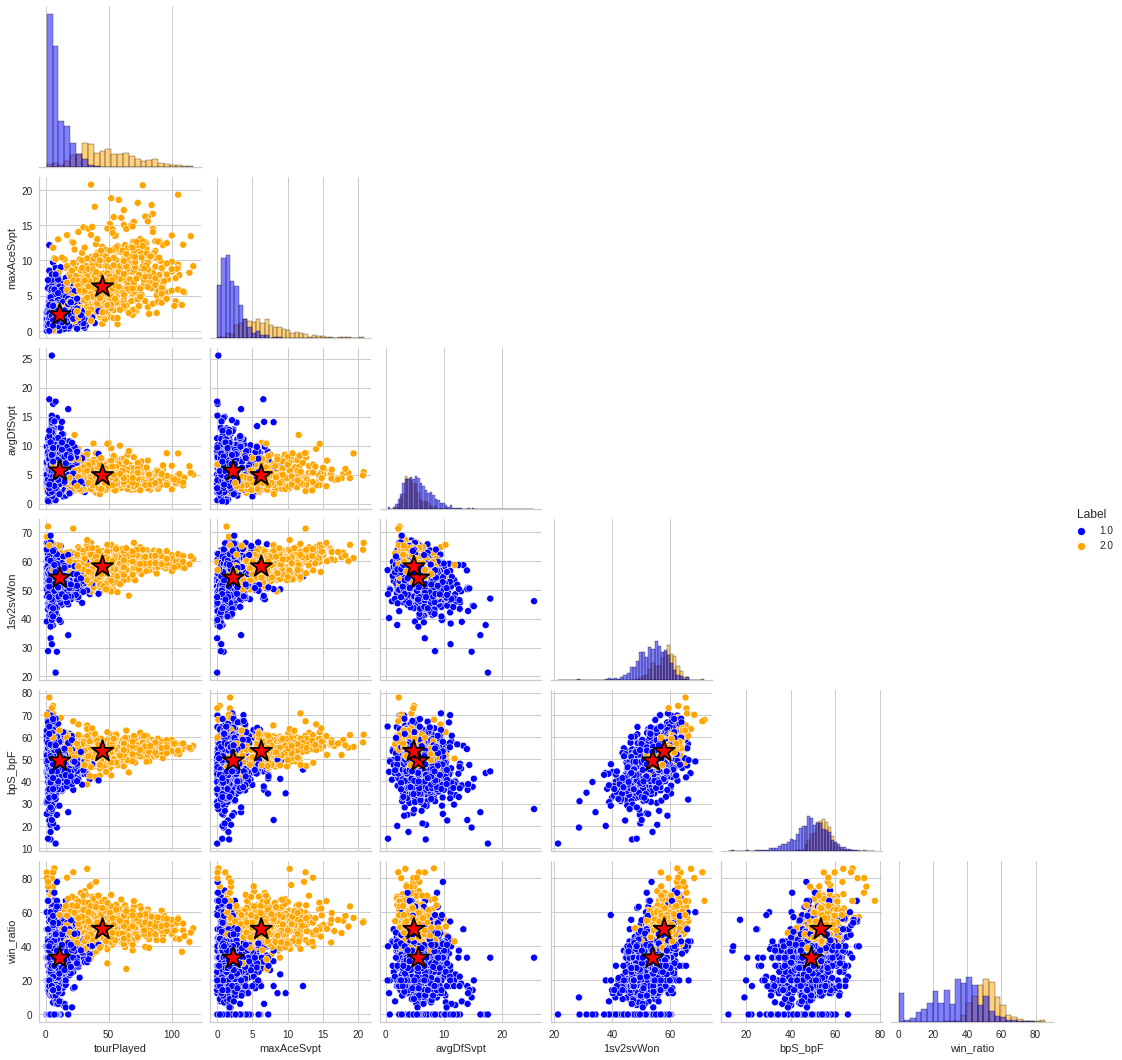

In [73]:
df_centroids = pd.DataFrame(centers, columns=df_clst.columns[:-1])
df_centroids['Label'] = list(range(1,len(clusters)+1))
sns.color_palette()
g = sns.pairplot(
    df_clst, 
    hue="Label", 
    corner=True, 
    diag_kind="hist",
    palette=["blue", "orange"])

g.data = df_centroids
g.hue_vals = list(range(0,len(clusters)))
g.map_offdiag(sns.scatterplot, s=500, marker="*", edgecolor="black", palette = ['red', 'red'])

plt.show()

We found out that the result of Fuzzy clustering is very similar to the result of K-Means

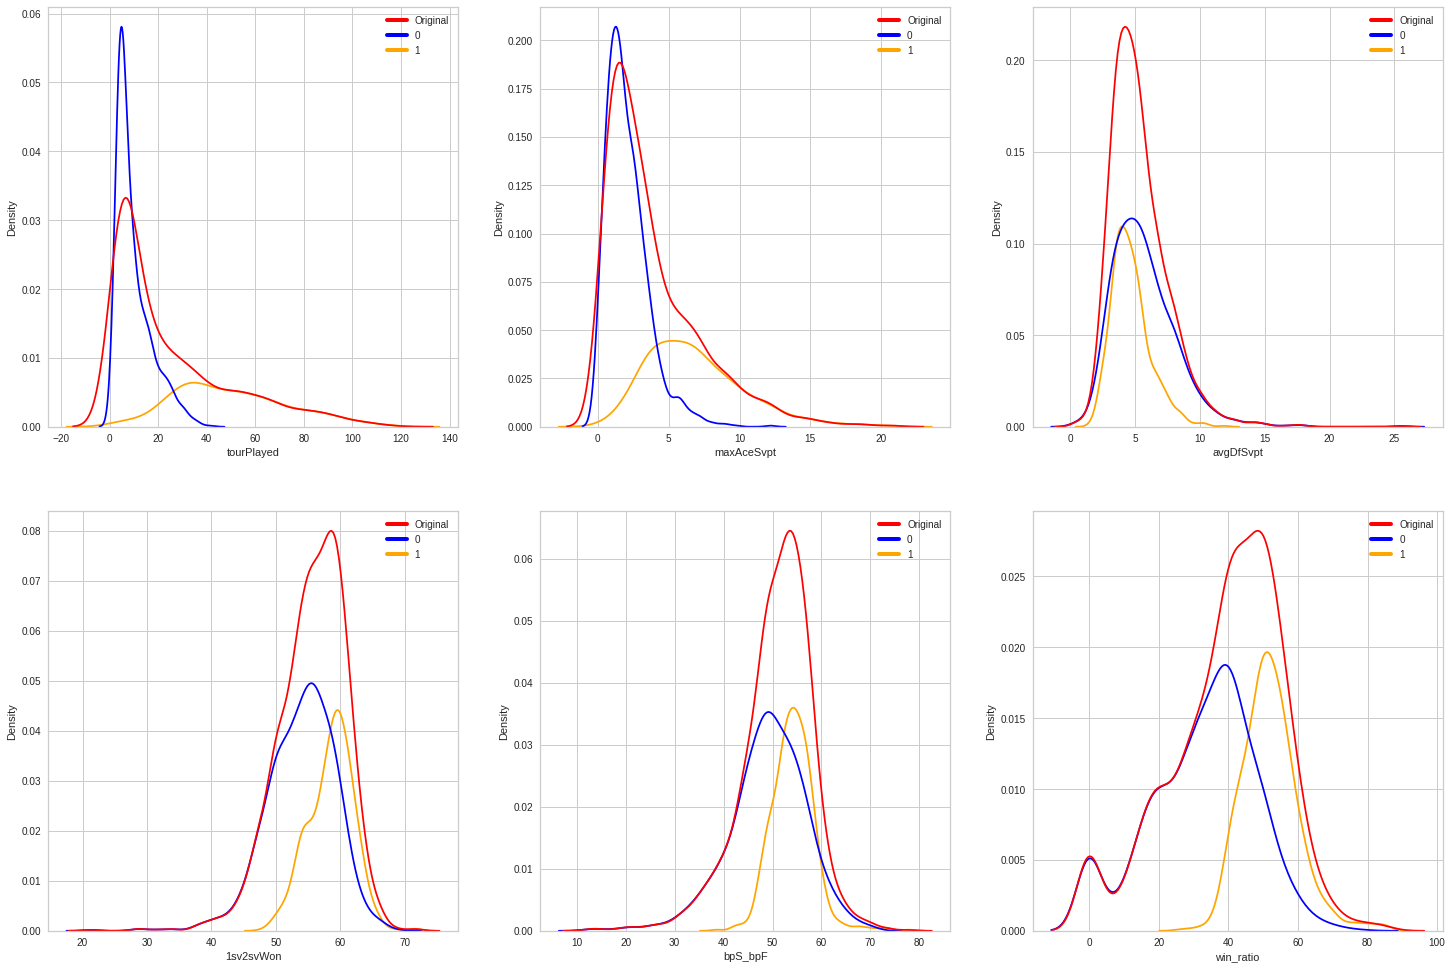

In [74]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(25, 17))

plot_id = 0
for i in range(len(df_clst.columns[:-1])):
    p1 = sns.kdeplot(
            data=df_clst[:-1], 
            x=f"{df_clst.columns[i]}", 
            hue="Label",
            ax=axs[int(plot_id / 3)][plot_id % 3],
            palette=cluster_colors,
            legend=False
        ) 

    legend_elements = [
        Line2D([0], [0], color='red', lw=4, label='Original'),
        Line2D([0], [0], color=cluster_colors[0], lw=4, label='0'),
        Line2D([0], [0], color=cluster_colors[1], lw=4, label='1'),]
    p1.legend(handles=legend_elements)

    sns.kdeplot(
        data=df_clst[:-1], 
        x=f"{df_clst.columns[i]}", 
        ax=axs[int(plot_id / 3)][plot_id % 3],
        color="red"
    ) 
    plot_id += 1

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=bd0371f1-26bc-4fa2-b3a3-1a163a949e34' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>